## Exploratory Data Analysis

In [28]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option("max_colwidth", None)

In [29]:
def import_dataset(filename):
    bank_mkt = pd.read_csv(filename,
                           na_values=["unknown", "nonexistent"],
                           true_values=["yes", "success"],
                           false_values=["no", "failure"])
    # Treat pdays = 999 as missing values
    bank_mkt["pdays"] = bank_mkt["pdays"].replace(999, pd.NA)
    # Convert types, "Int64" is nullable integer data type in pandas
    bank_mkt = bank_mkt.astype(dtype={"age": "Int64",
                                      "job": "category",
                                      "marital": "category",
                                      "education": "category",
                                      "default": "boolean",
                                      "housing": "boolean",
                                      "loan": "boolean",
                                      "contact": "category",
                                      "month": "category",
                                      "day_of_week": "category",
                                      "duration": "Int64",
                                      "campaign": "Int64",
                                      "pdays": "Int64",
                                      "previous": "Int64",
                                      "poutcome": "boolean",
                                      "y": "boolean"})
    return bank_mkt

In [30]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

There are many visualization libraries in Python. Pandas has its own plot API based on `matplotlib` and we will also use Seaborn and Altair. Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics. Altair is a declarative statistical visualization library for Python, based on Vega and Vega-Lite. Both libraries provide easy to use APIs and produce beautiful graphs.

In [31]:
import altair as alt
import matplotlib.pyplot as plt
# cosmetic options for matplotlib
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (20/2.54, 8/2.54)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlepad"] = 10.0
plt.rcParams["axes.titlelocation"] = "left"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("png")
import seaborn as sns

Let's first inpect the outcome distribution. As we can see below, the dataset is imbalanced. With 41188 rows of data, only 11.2% have positive outcome.

In [32]:
bank_mkt["y"].count()

41188

In [33]:
bank_mkt["y"].sum()/bank_mkt["y"].count()

0.11265417111780131

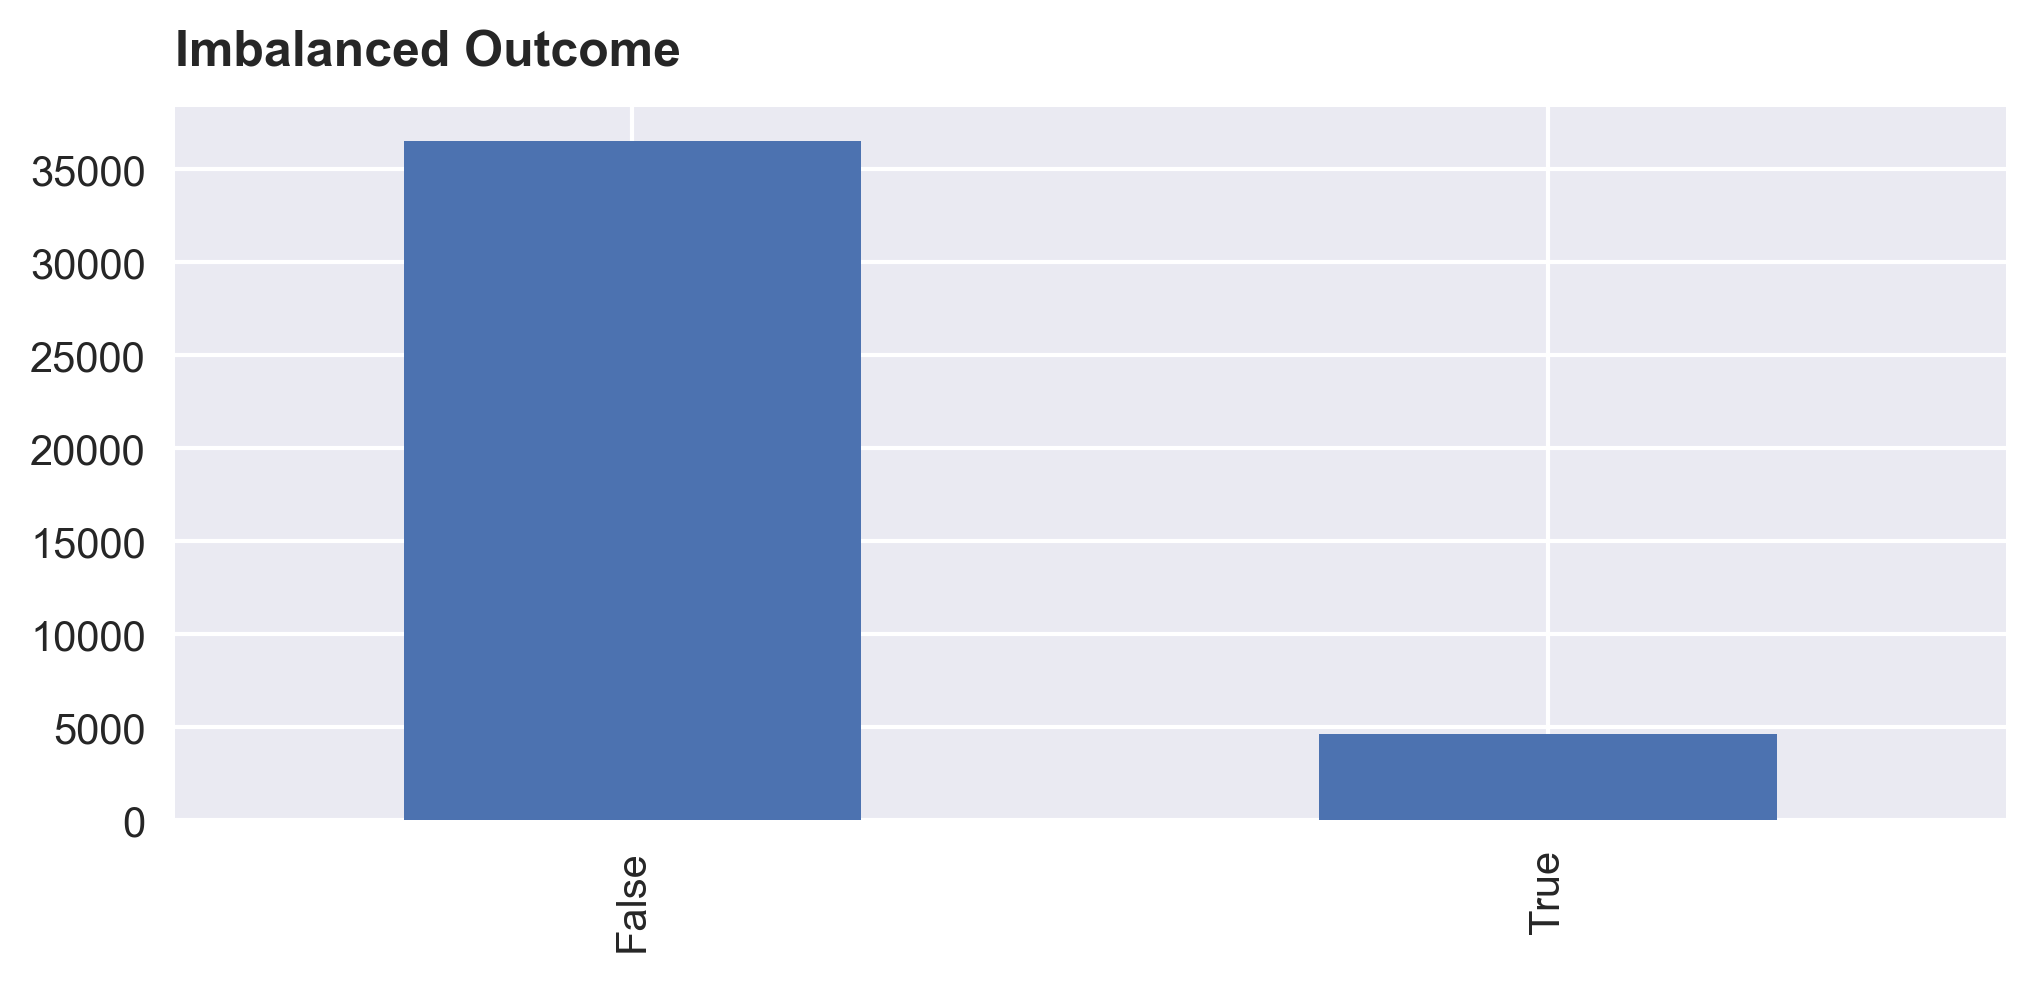

In [34]:
y_count = bank_mkt["y"].value_counts().plot(kind = "bar", title="Imbalanced Outcome")

Using `info()` we can see that most of features concerning the client are categorical/boolean type. And some fields such as `job`, `marital`, `education`, etc. are missing.

In [35]:
bank_mkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  Int64   
 1   job             40858 non-null  category
 2   marital         41108 non-null  category
 3   education       39457 non-null  category
 4   default         32591 non-null  boolean 
 5   housing         40198 non-null  boolean 
 6   loan            40198 non-null  boolean 
 7   contact         41188 non-null  category
 8   month           41188 non-null  category
 9   day_of_week     41188 non-null  category
 10  duration        41188 non-null  Int64   
 11  campaign        41188 non-null  Int64   
 12  pdays           1515 non-null   Int64   
 13  previous        41188 non-null  Int64   
 14  poutcome        5625 non-null   boolean 
 15  emp.var.rate    41188 non-null  float64 
 16  cons.price.idx  41188 non-null  float64 
 17  cons.conf.id

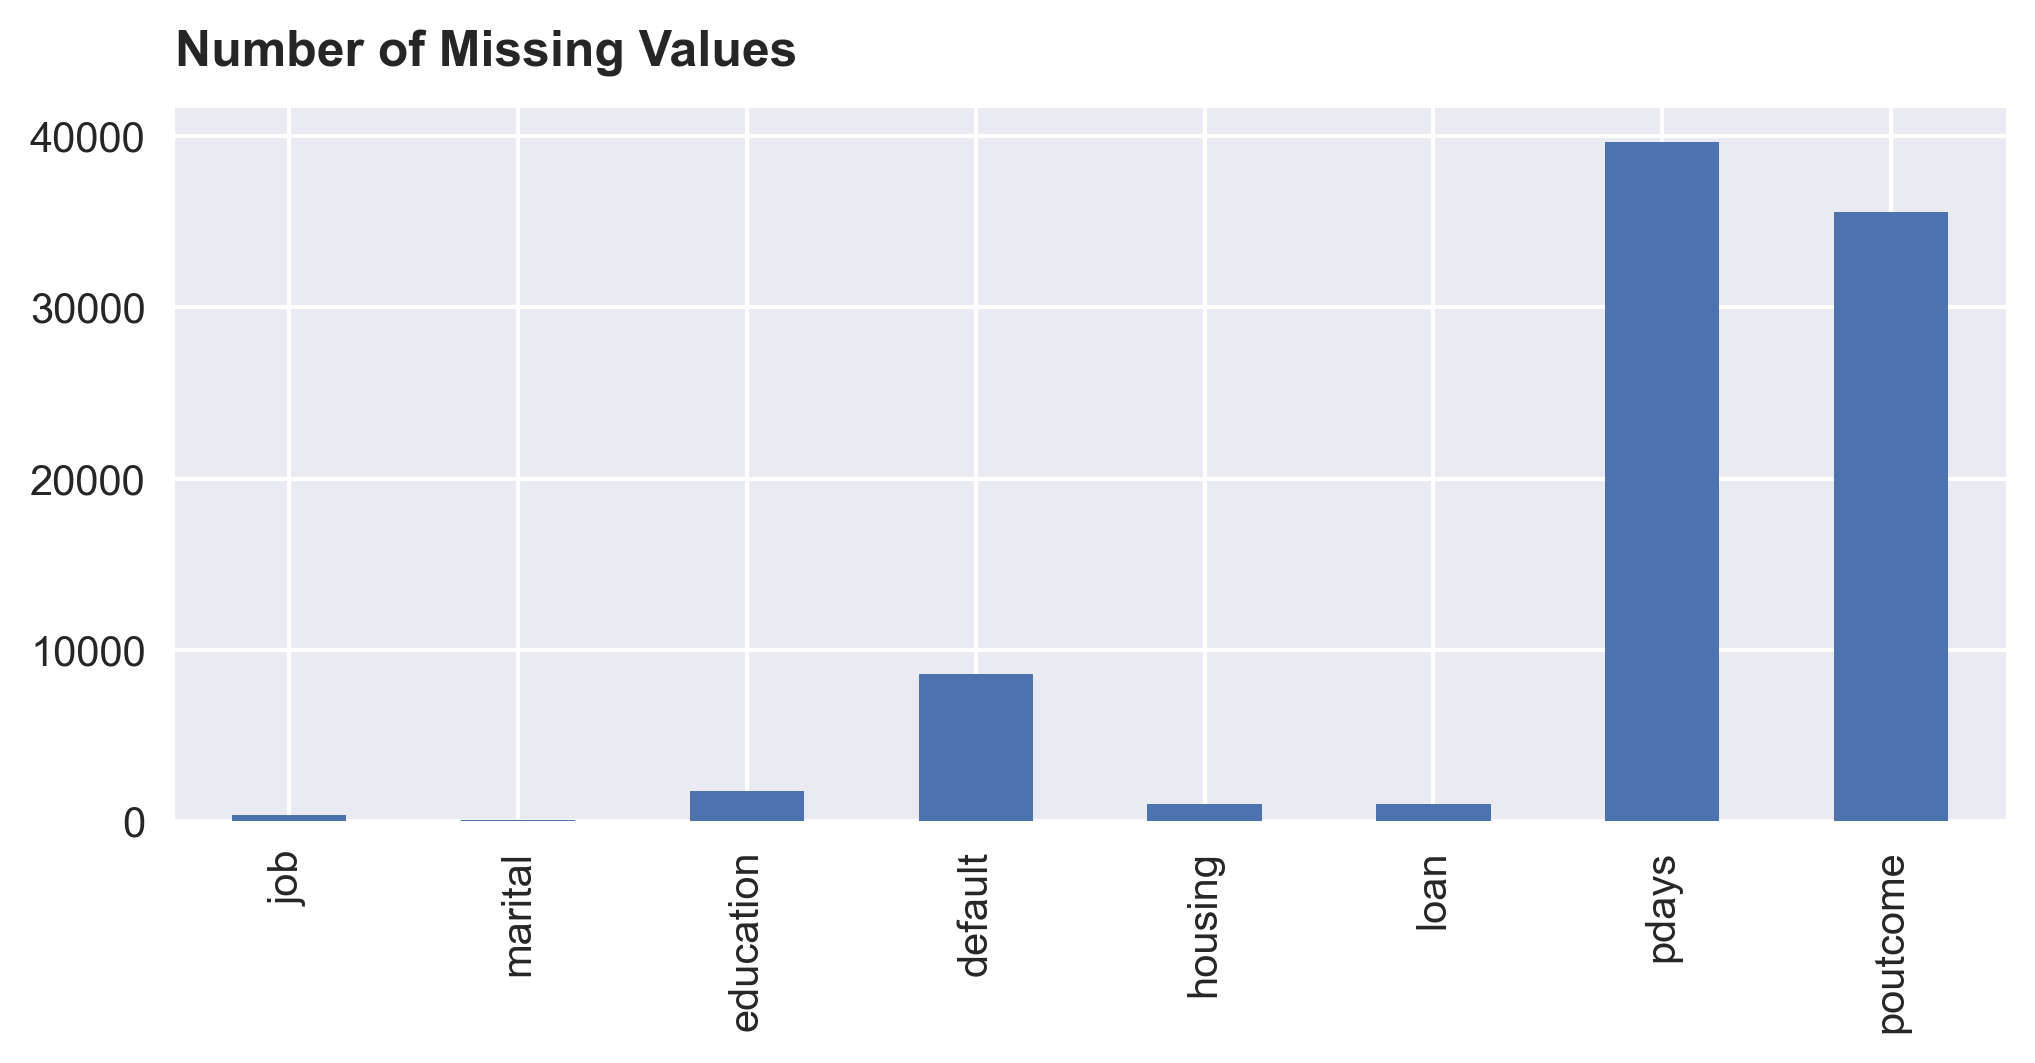

### Client Data

Let's start with age distribution. Most of the clients's age are between 32 to 47 while there are some outlier cases beyond 70. This may imply that we should choose standardization for scaling since it's more tolerant for outliers.

In [36]:
bank_mkt["age"].describe()

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

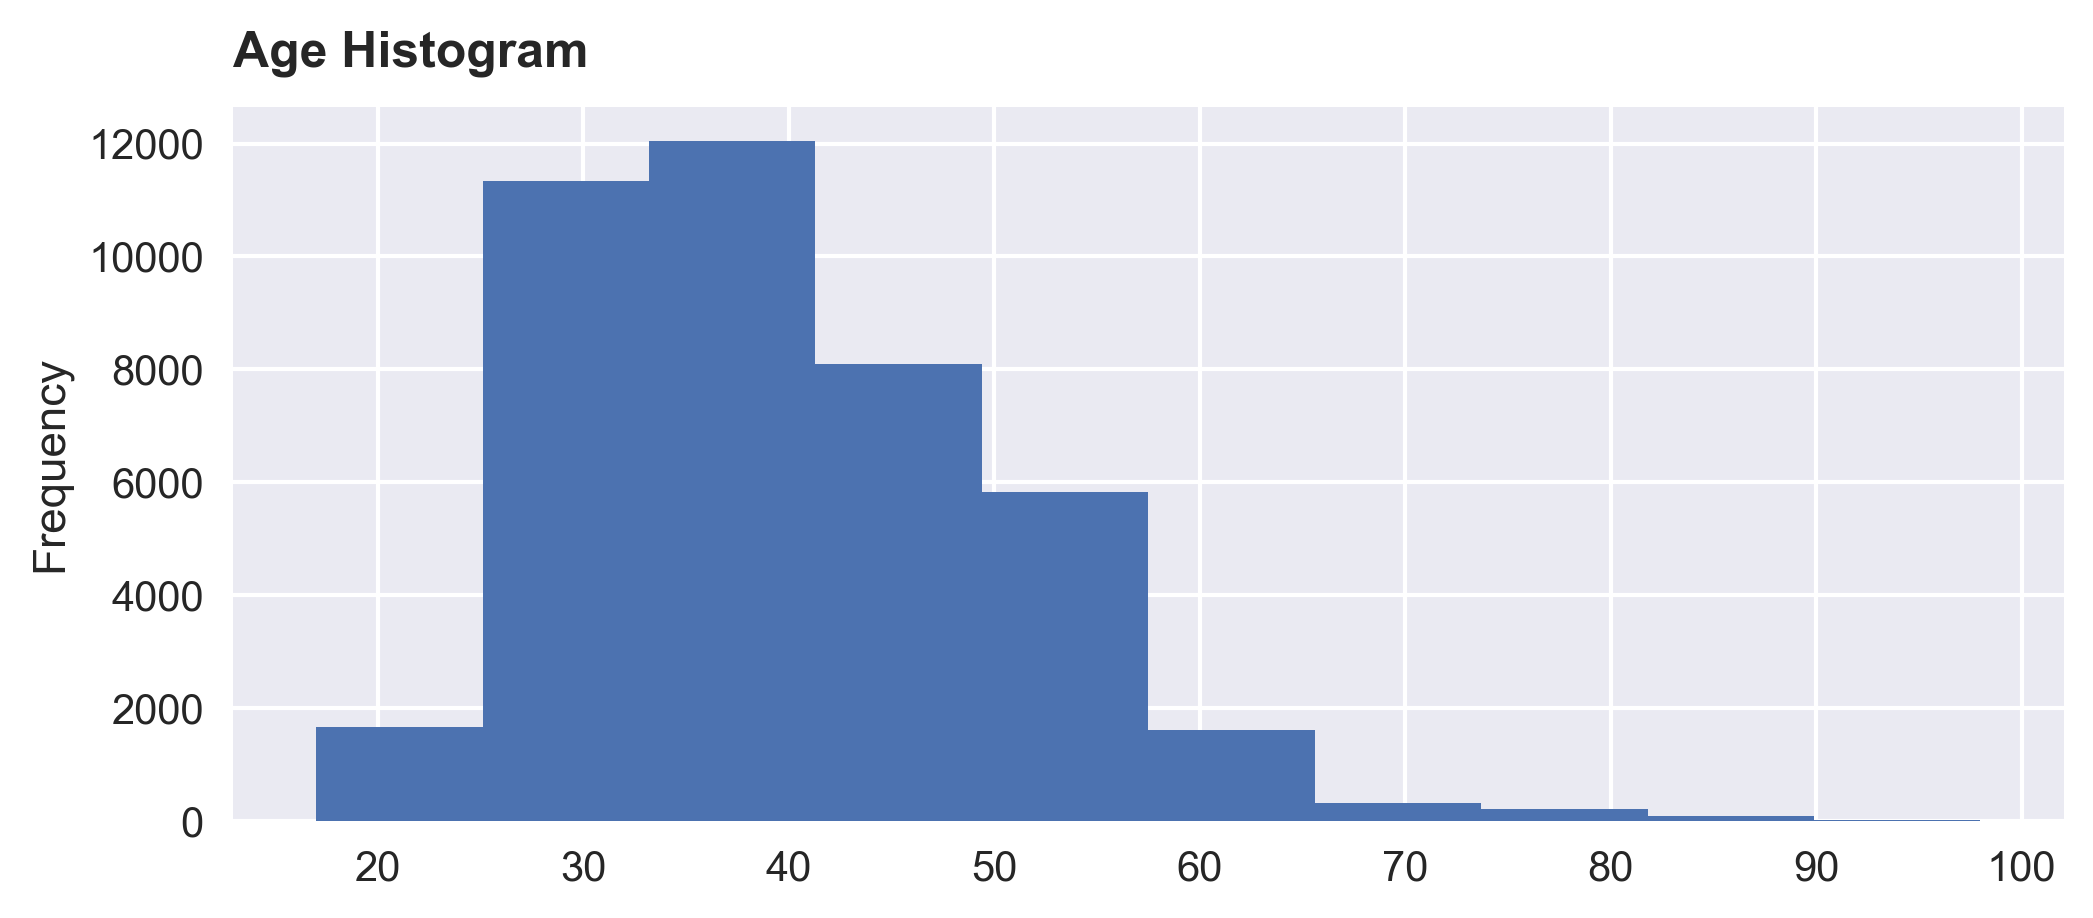

In [37]:
age_hist = bank_mkt["age"].plot.hist(title="Age Histogram")

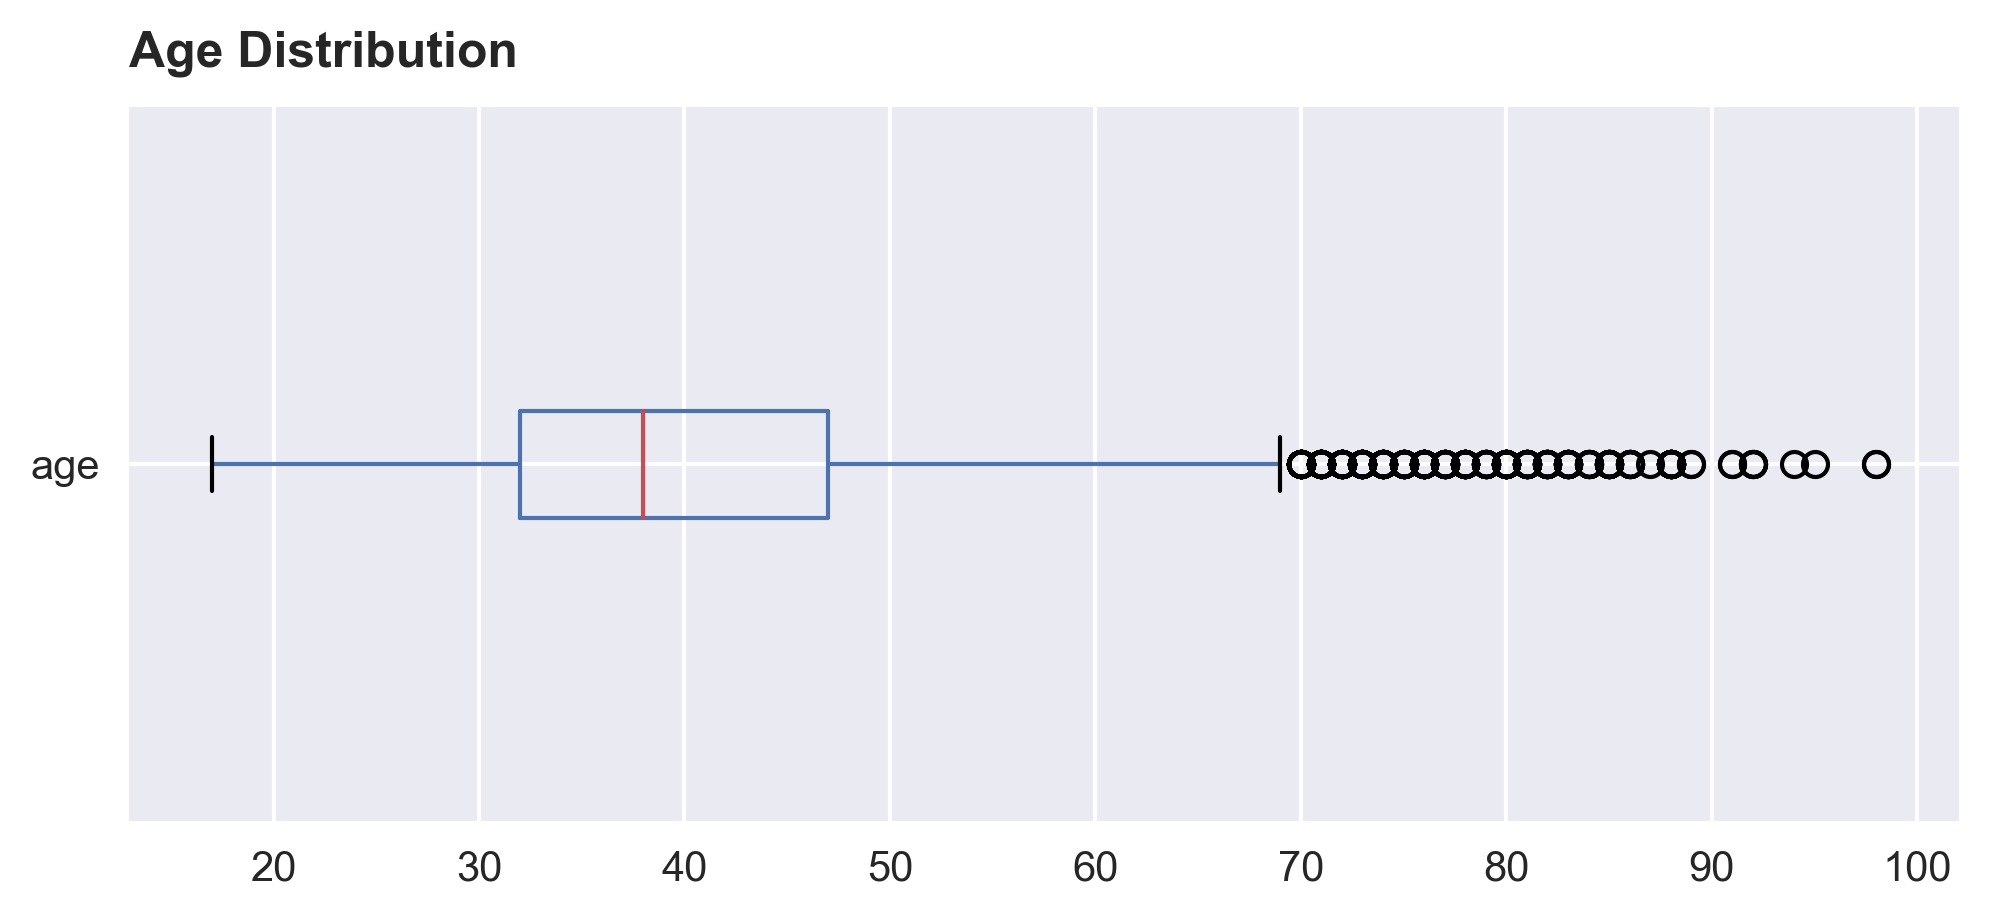

In [38]:
age_box = bank_mkt["age"].plot.box(vert=False, title="Age Distribution")

From the graph below we can see that the age distribution in the true outcome group has lower median age but is more skewed toward an slightly older population.

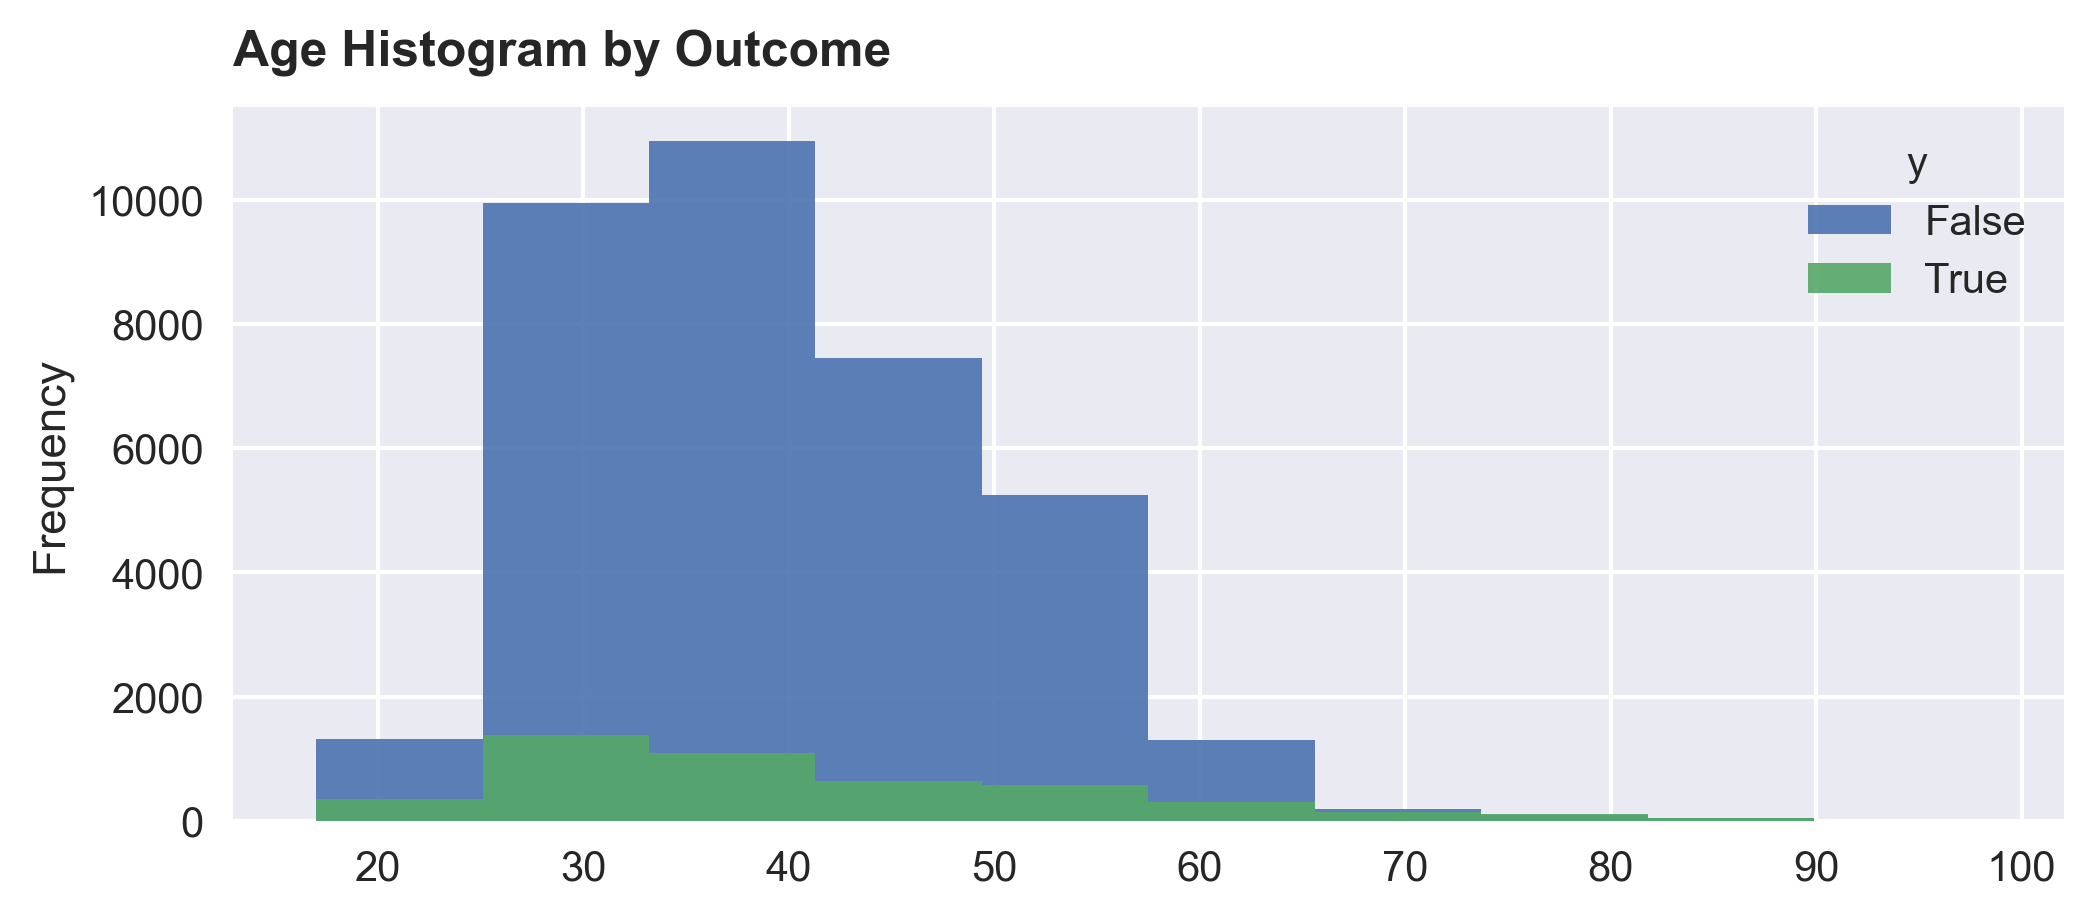

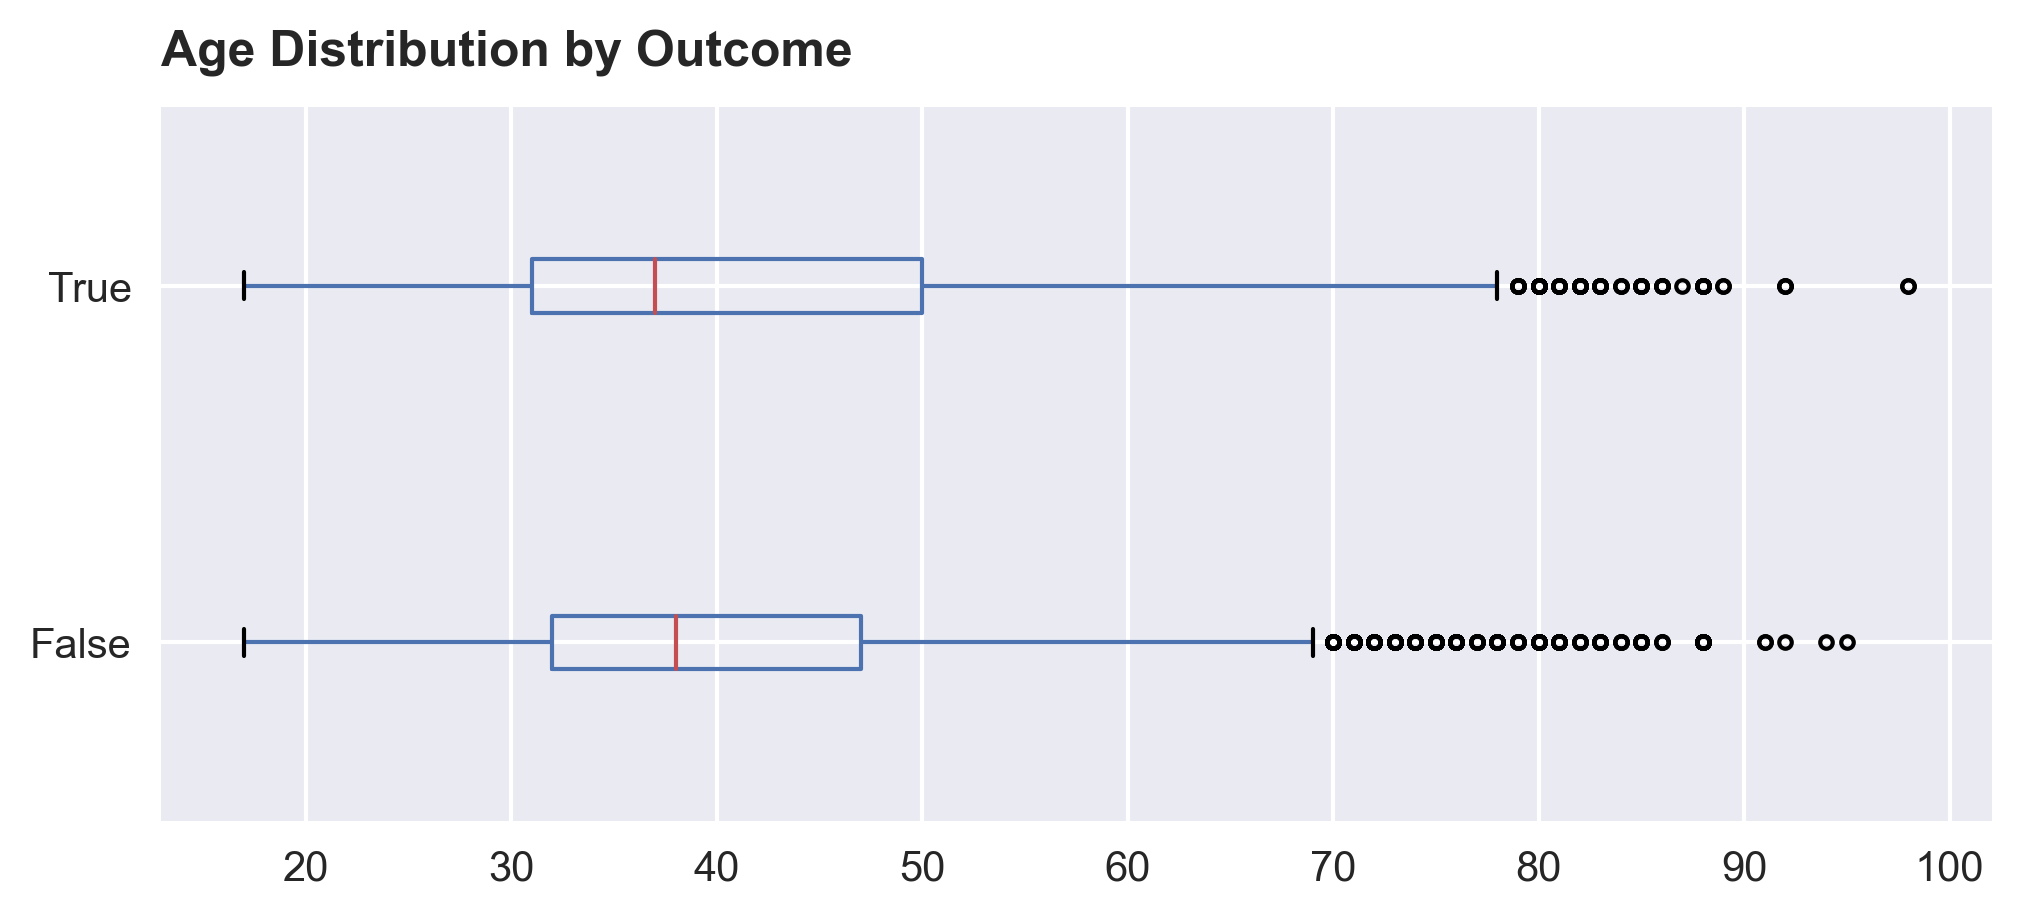

In [52]:
age_y = bank_mkt[["age", "y"]].pivot(columns="y", values="age")
age_hist_outcome = age_y.plot.hist(alpha=0.9, legend=True, title="Age Histogram by Outcome")
age_box_outcome = age_y.plot.box(vert=False, sym=".", title="Age Distribution by Outcome")

We can also inspect the relationship between age and other categorical values.

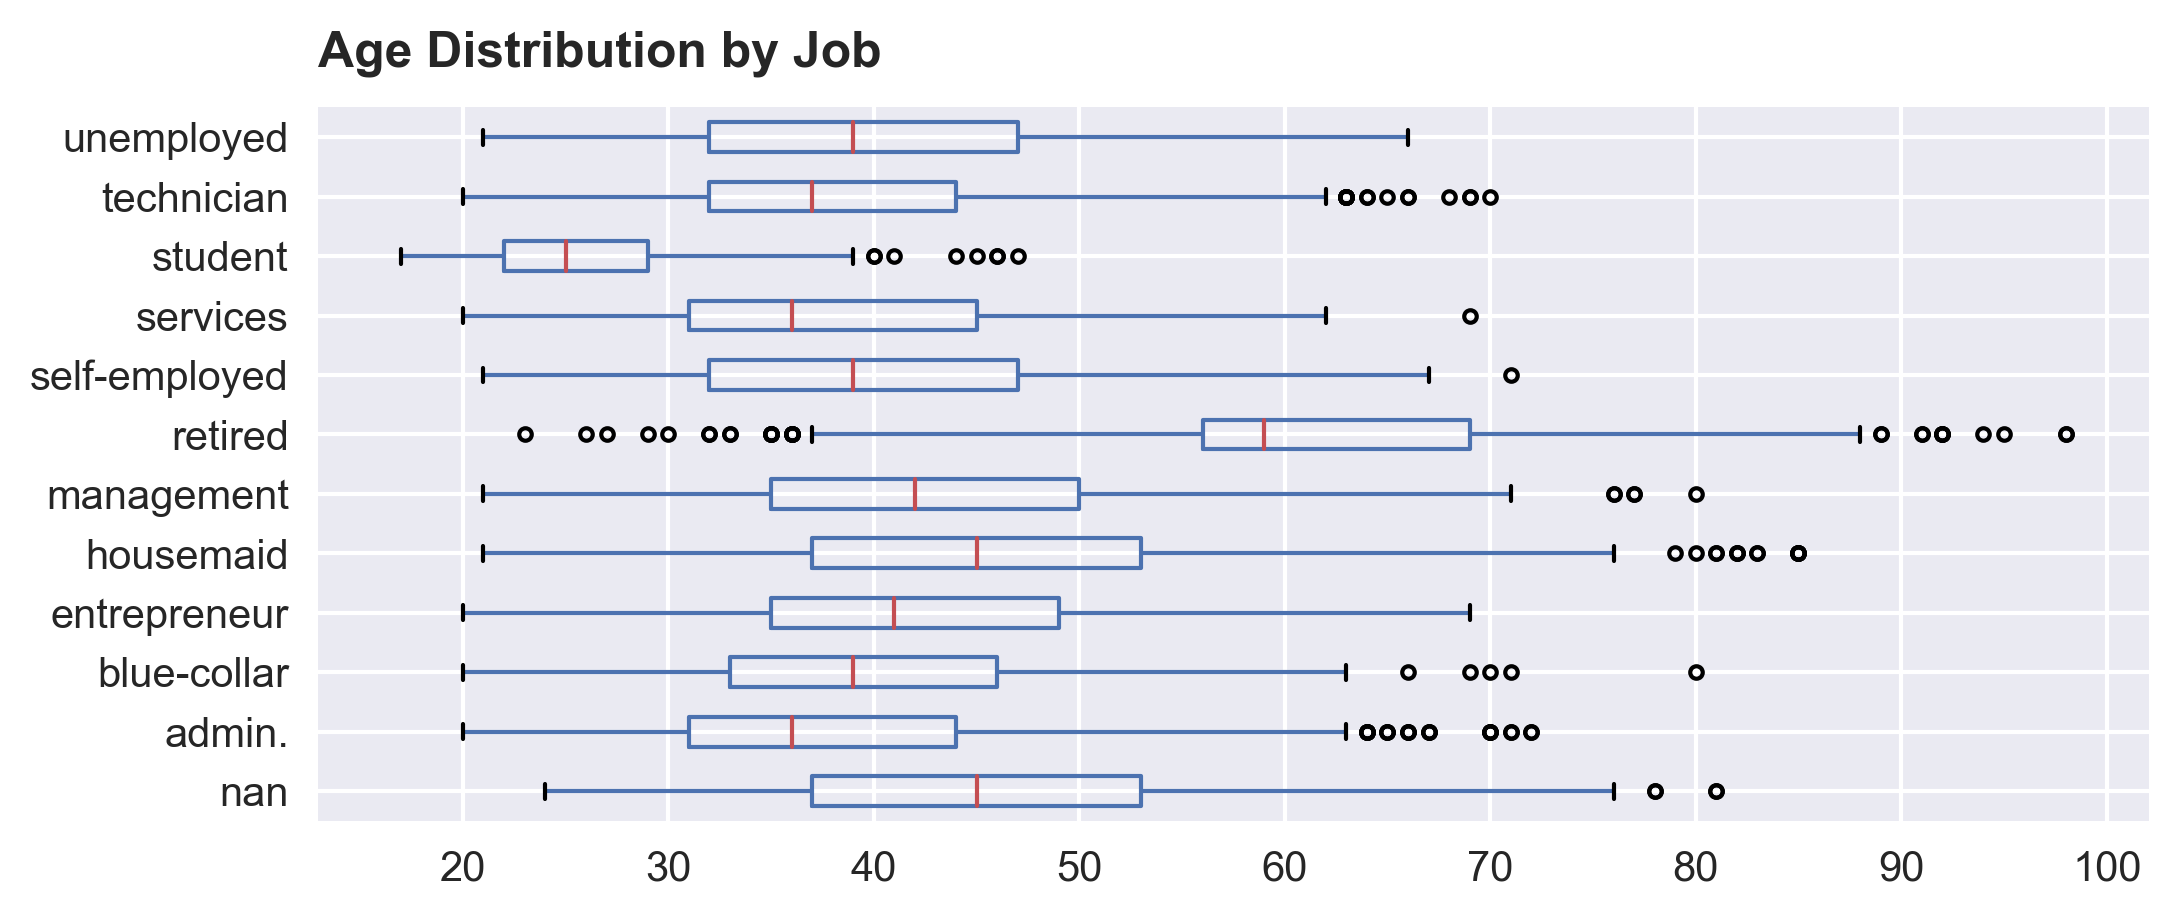

In [53]:
age_job = bank_mkt[["age", "job"]].pivot(columns="job", values="age")
age_job_box = age_job.plot.box(vert=False, sym=".", title="Age Distribution by Job")

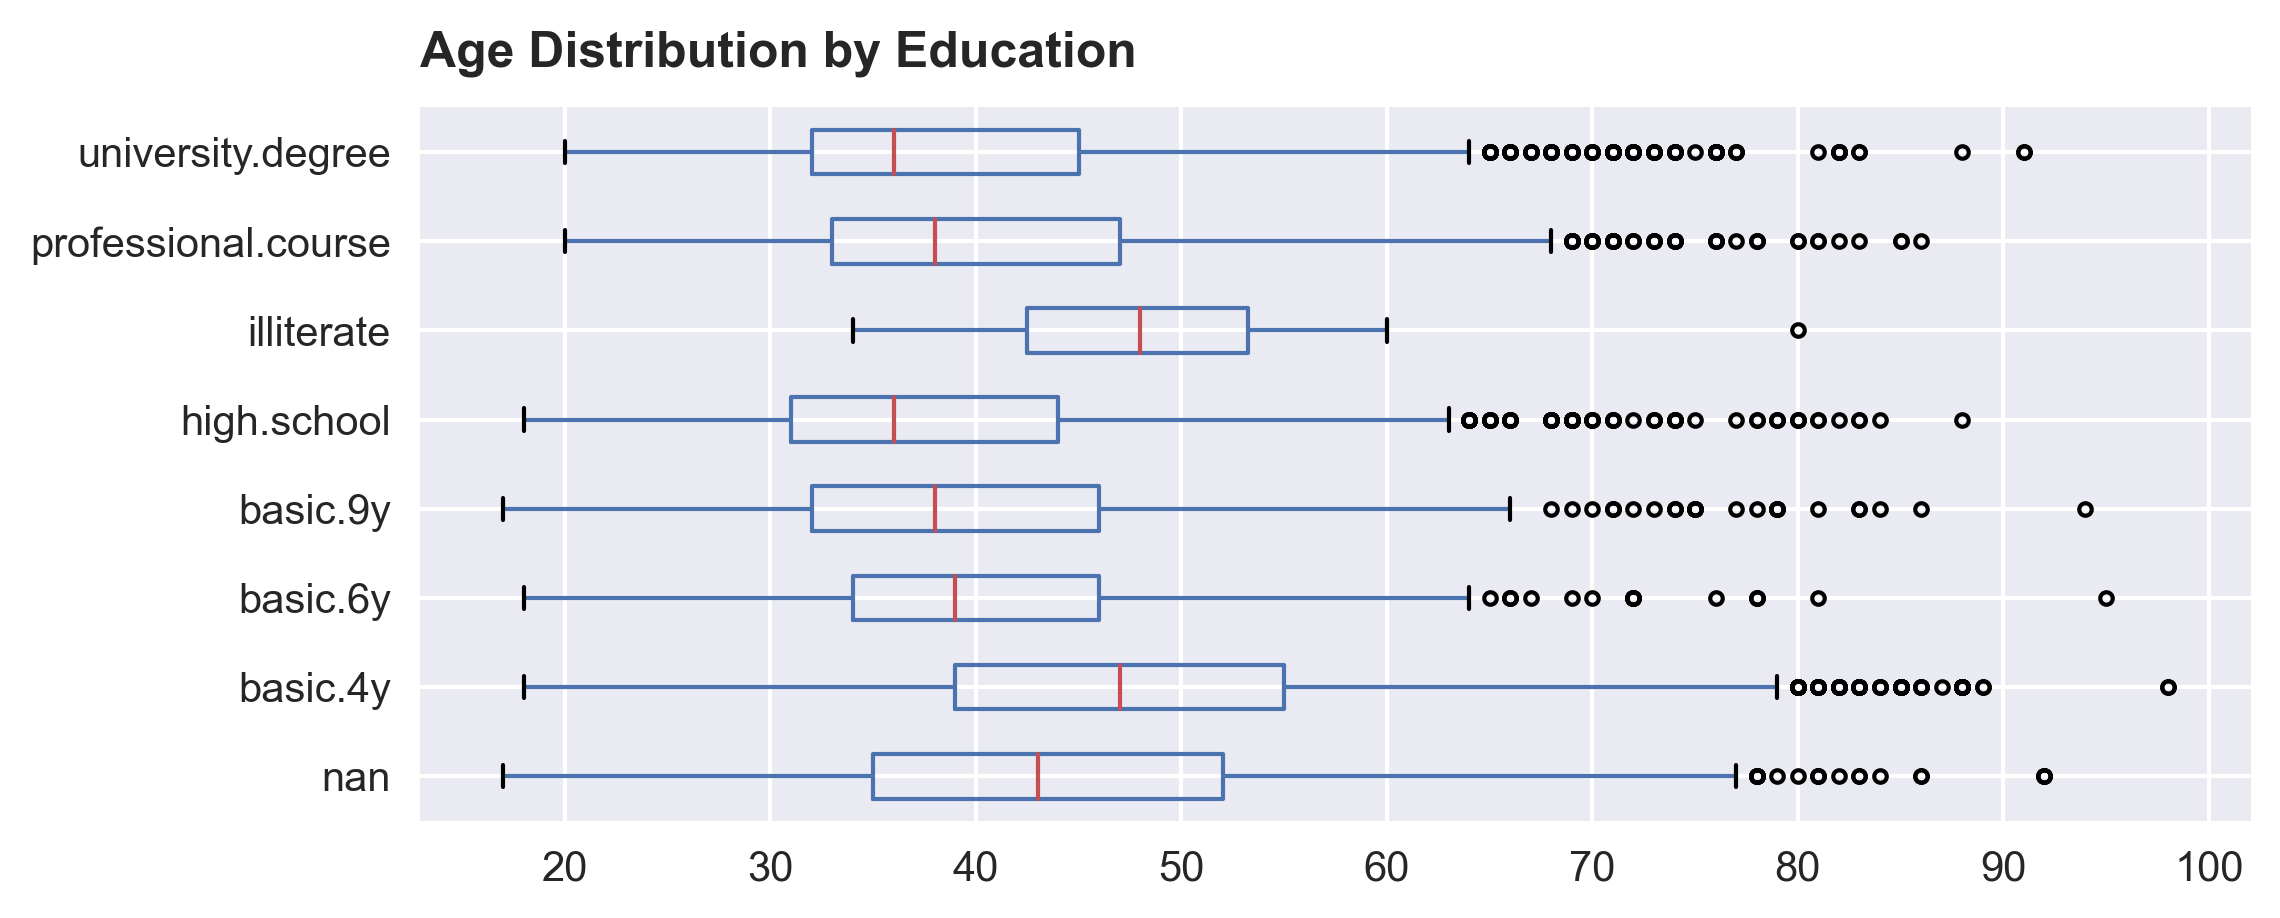

In [54]:
age_education = bank_mkt[["age", "education"]].pivot(columns="education", values="age")
age_education_box = age_education.plot.box(vert=False, sym=".", title="Age Distribution by Education")

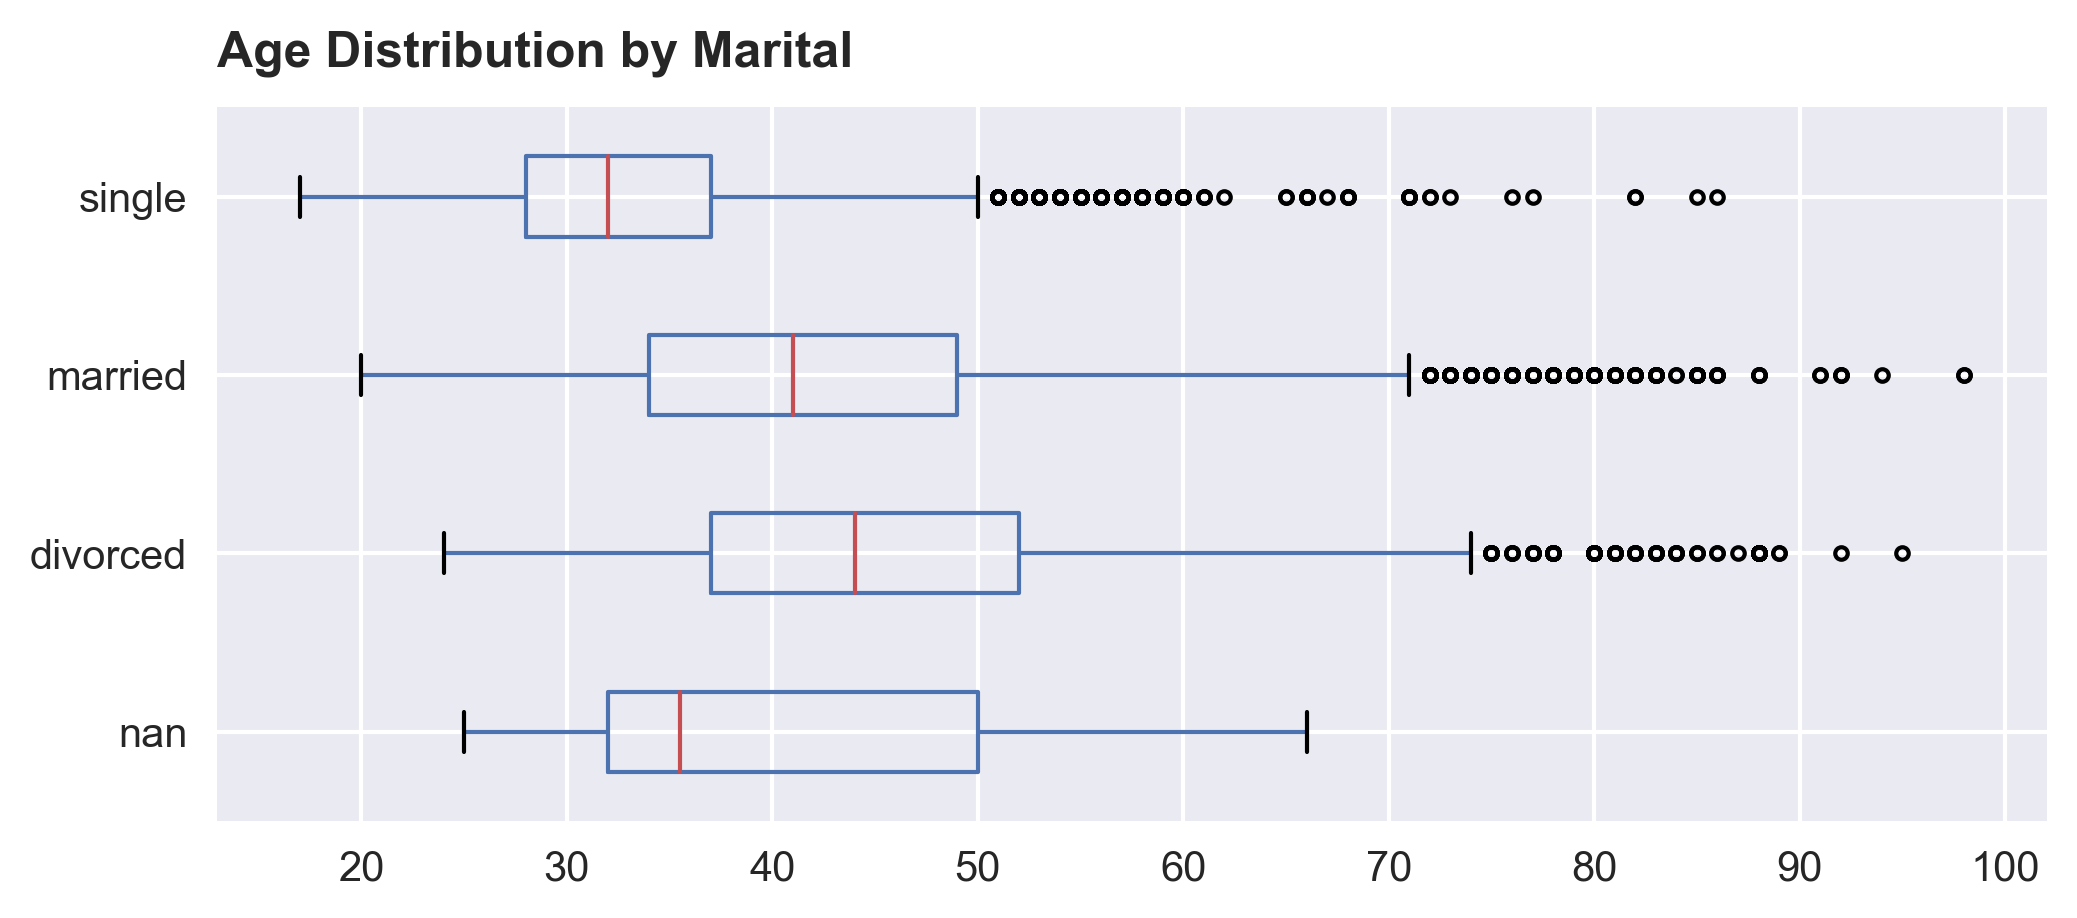

In [55]:
age_marital = bank_mkt[["age", "marital"]].pivot(columns="marital", values="age")
age_marital_box = age_marital.plot.box(vert=False, sym=".", title="Age Distribution by Marital")

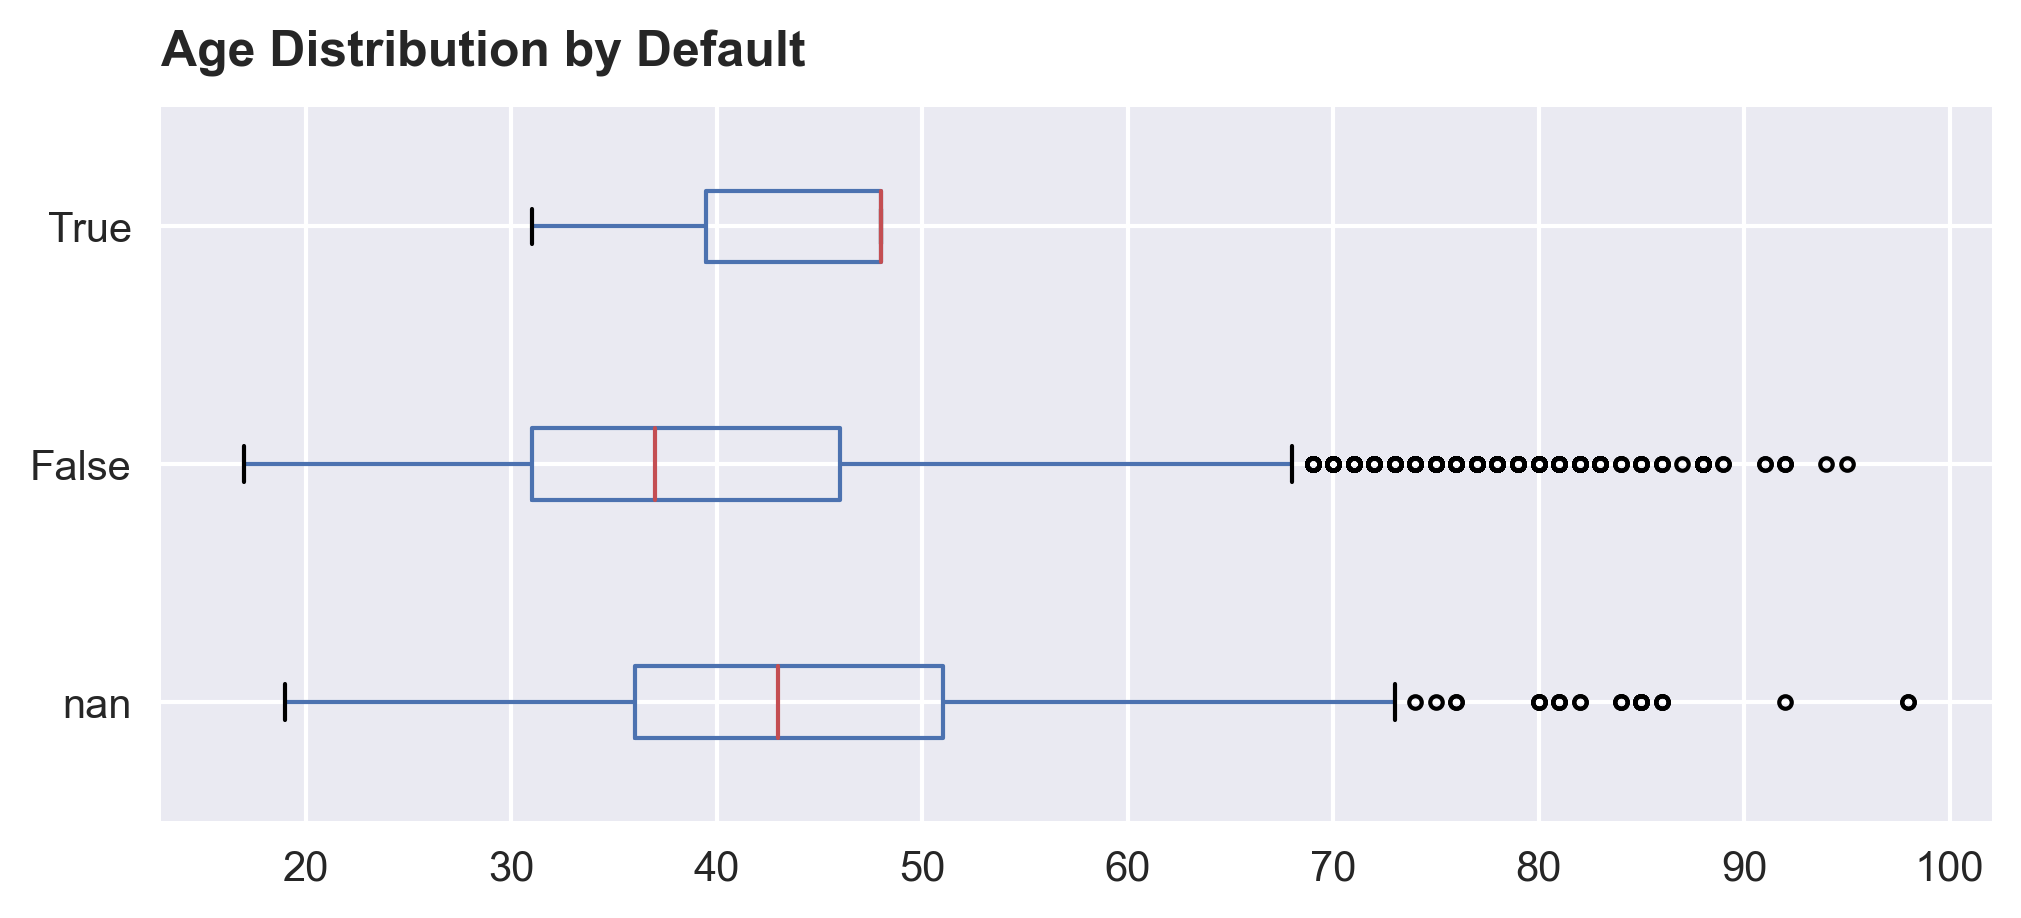

In [56]:
age_default = bank_mkt[["age", "default"]].pivot(columns="default", values="age")
age_default_box = age_default.plot.box(vert=False, sym=".", title="Age Distribution by Default")

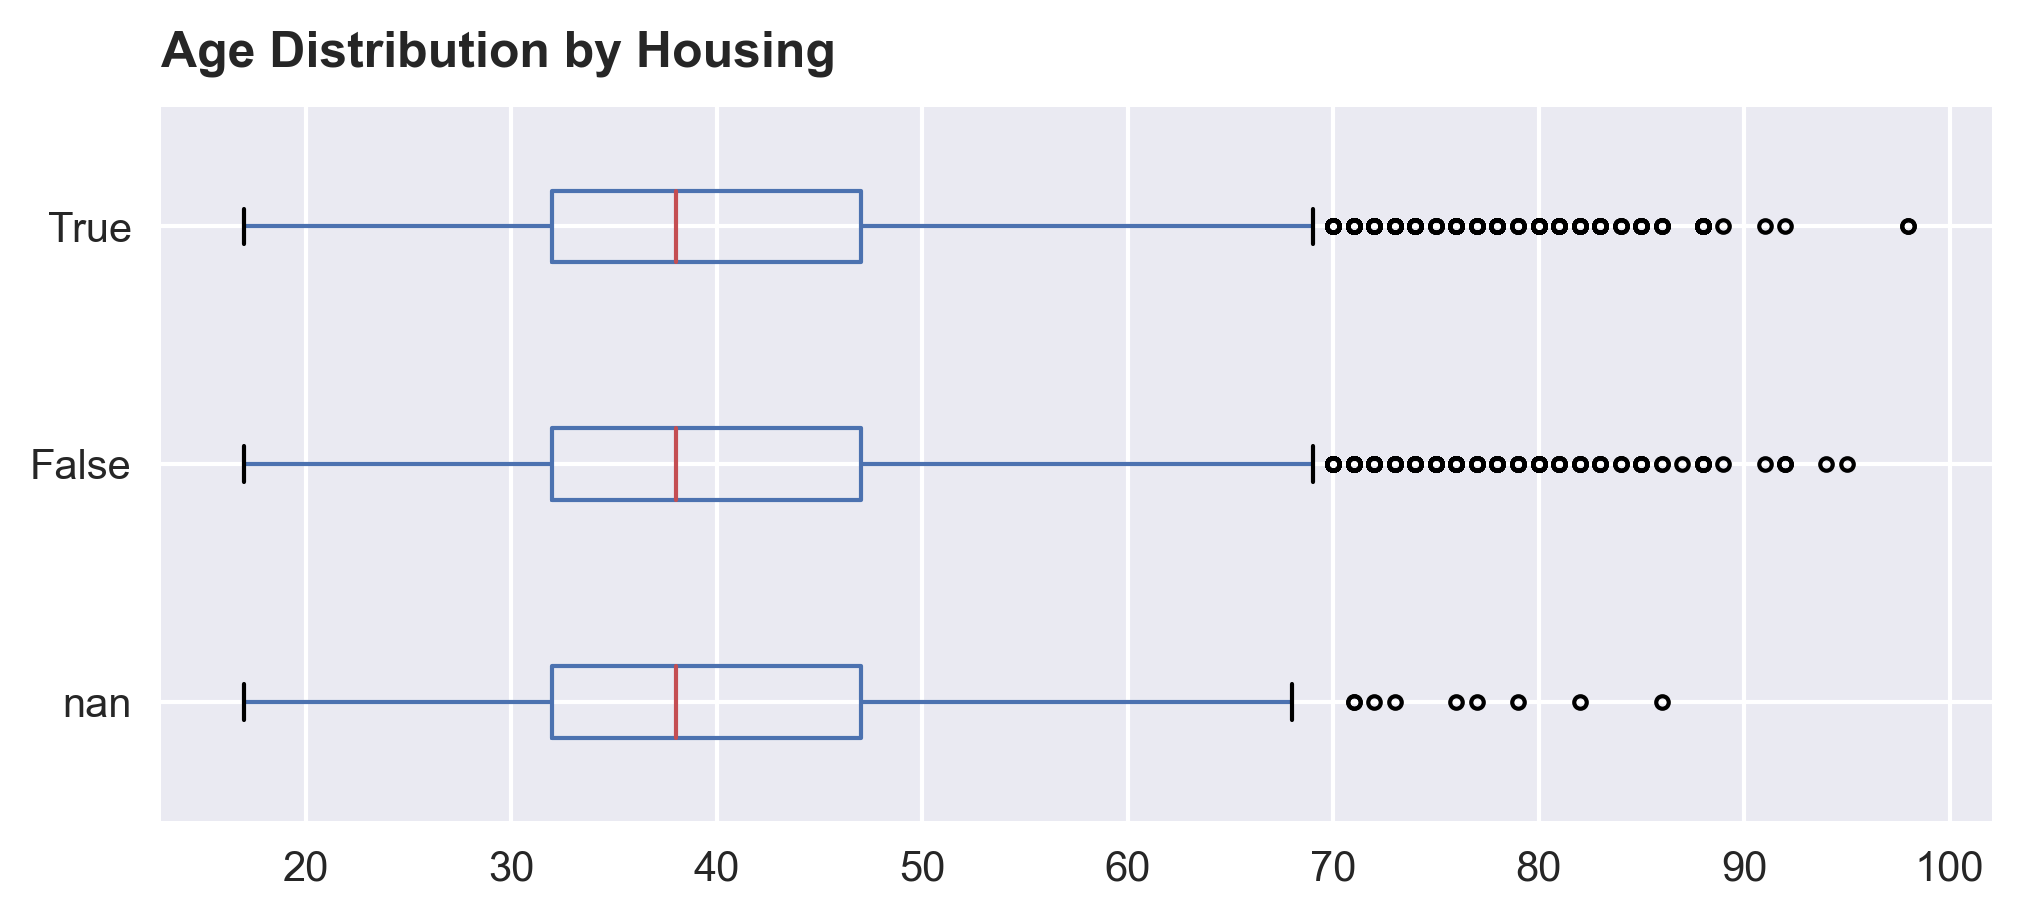

In [57]:
age_housing = bank_mkt[["age", "housing"]].pivot(columns="housing", values="age")
age_housing_box = age_housing.plot.box(vert=False, sym=".", title="Age Distribution by Housing")

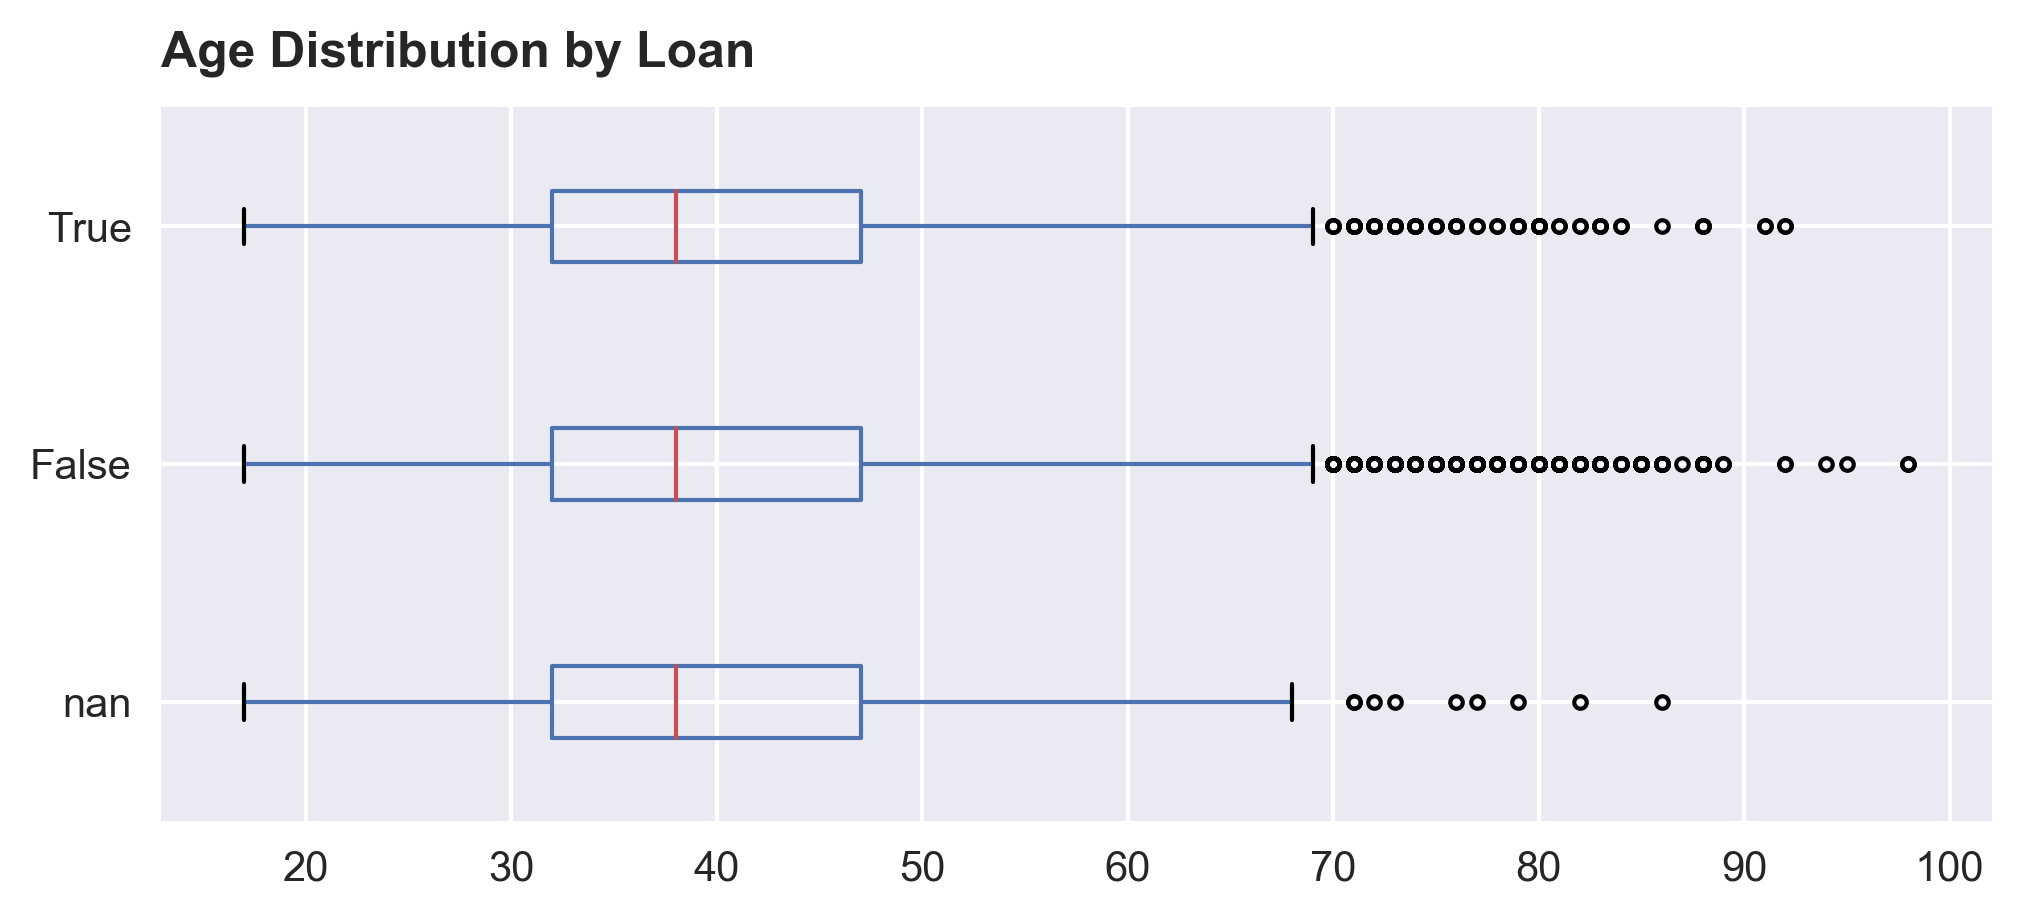

In [58]:
age_loan = bank_mkt[["age", "loan"]].pivot(columns="loan", values="age")
age_loan_box = age_loan.plot.box(vert=False, sym=".", title="Age Distribution by Loan")

We can then turn to job, eductaion and other categorical data to see their relationship to the outcome.

In [46]:
def explore_cat(df, feature):
    df = df.copy()
    if pd.api.types.is_categorical_dtype(df[feature]):
        df[feature] = df[feature].cat.add_categories('unknown')
        df[feature] = df[feature].fillna("unknown")
    feature_true = df[[feature, "y"]].groupby([feature]).sum().y.rename("True")
    feature_total = df[[feature, "y"]].groupby([feature]).count().y.rename("Total")
    feature_false = feature_total - feature_true
    feature_false = feature_false.rename("False")
    feature_true_rate = feature_true / feature_total
    feature_true_rate = feature_true_rate.rename("True Percentage")
    return pd.concat([feature_true, feature_false, feature_total, feature_true_rate], axis=1) 

In [47]:
explore_cat(bank_mkt, "job")

,True,False,Total,True Percentage
job,,,,
admin.,1352,9070,10422,0.129726
blue-collar,638,8616,9254,0.068943
entrepreneur,124,1332,1456,0.085165
housemaid,106,954,1060,0.100000
management,328,2596,2924,0.112175
retired,434,1286,1720,0.252326
self-employed,149,1272,1421,0.104856
services,323,3646,3969,0.081381
student,275,600,875,0.314286


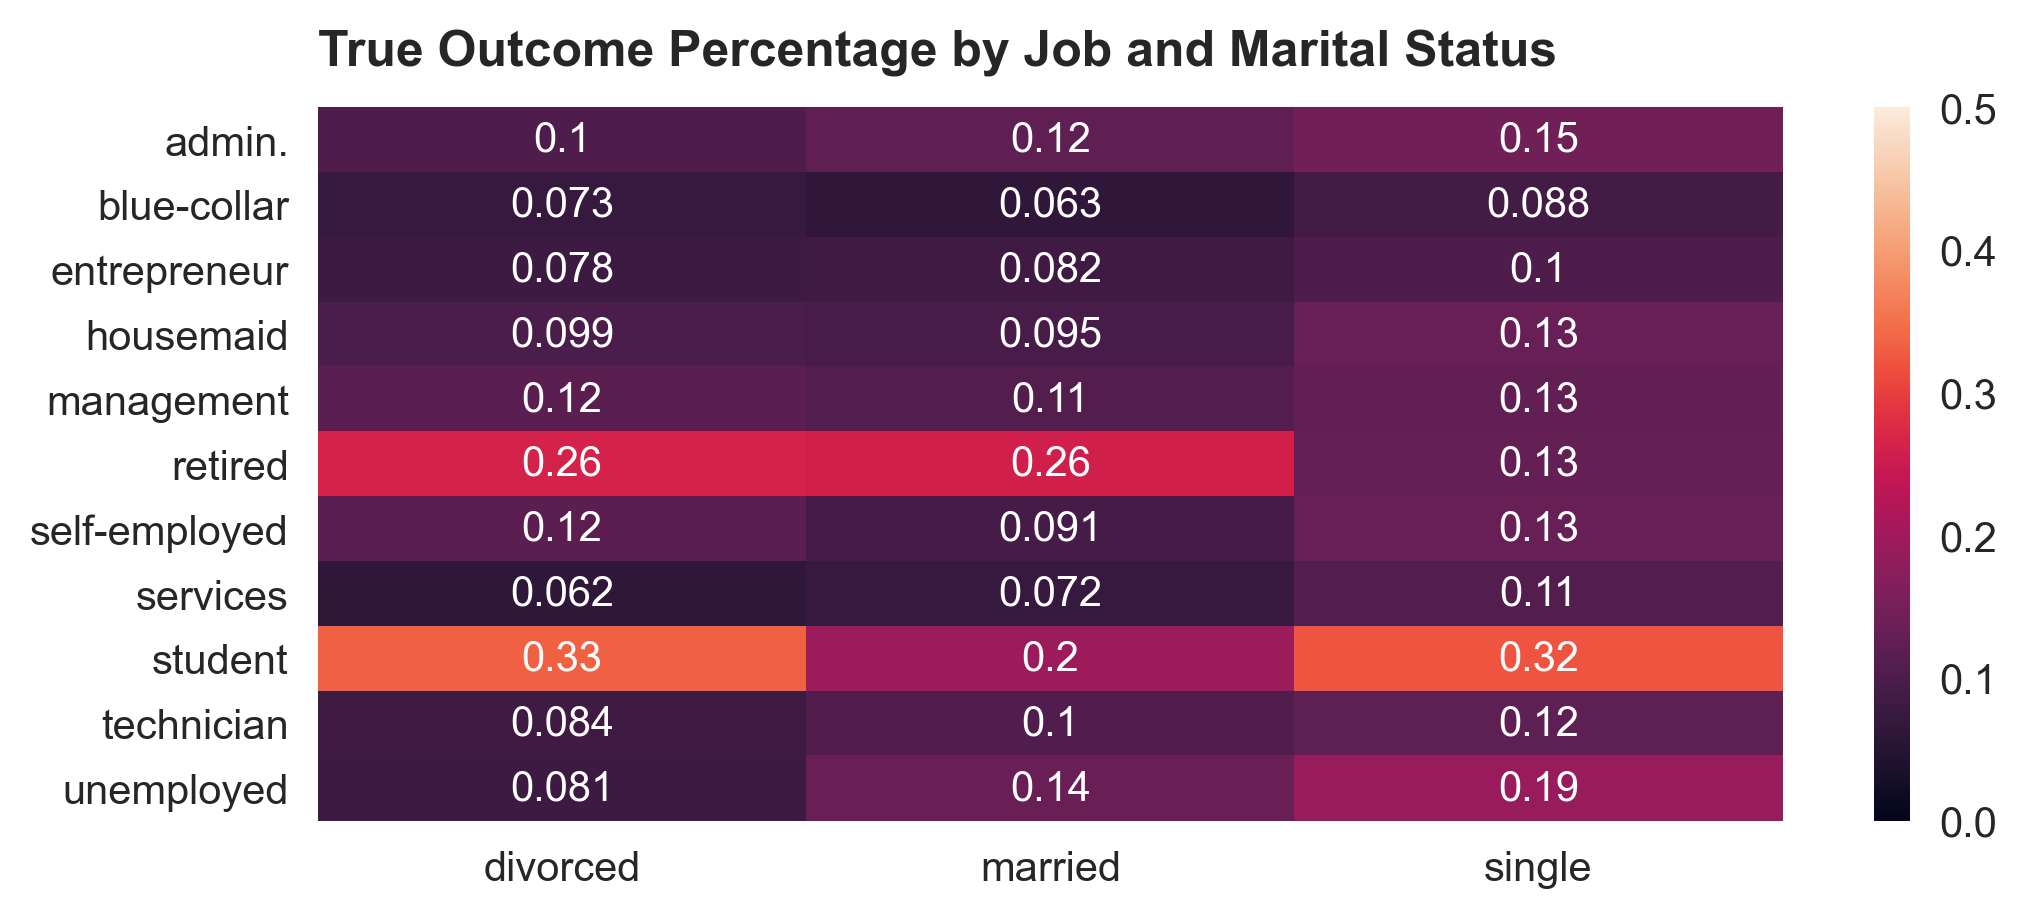

In [48]:
job_marital_total = bank_mkt[["job", "marital", "y"]].groupby(["job", "marital"]).count().y.unstack()
job_marital_true = bank_mkt[["job", "marital", "y"]].groupby(["job", "marital"]).sum().y.unstack()
job_marital_rate = job_marital_true / job_marital_total
job_marital_rate = job_marital_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
job_marital_heatmap = sns.heatmap(data=job_marital_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Job and Marital Status")

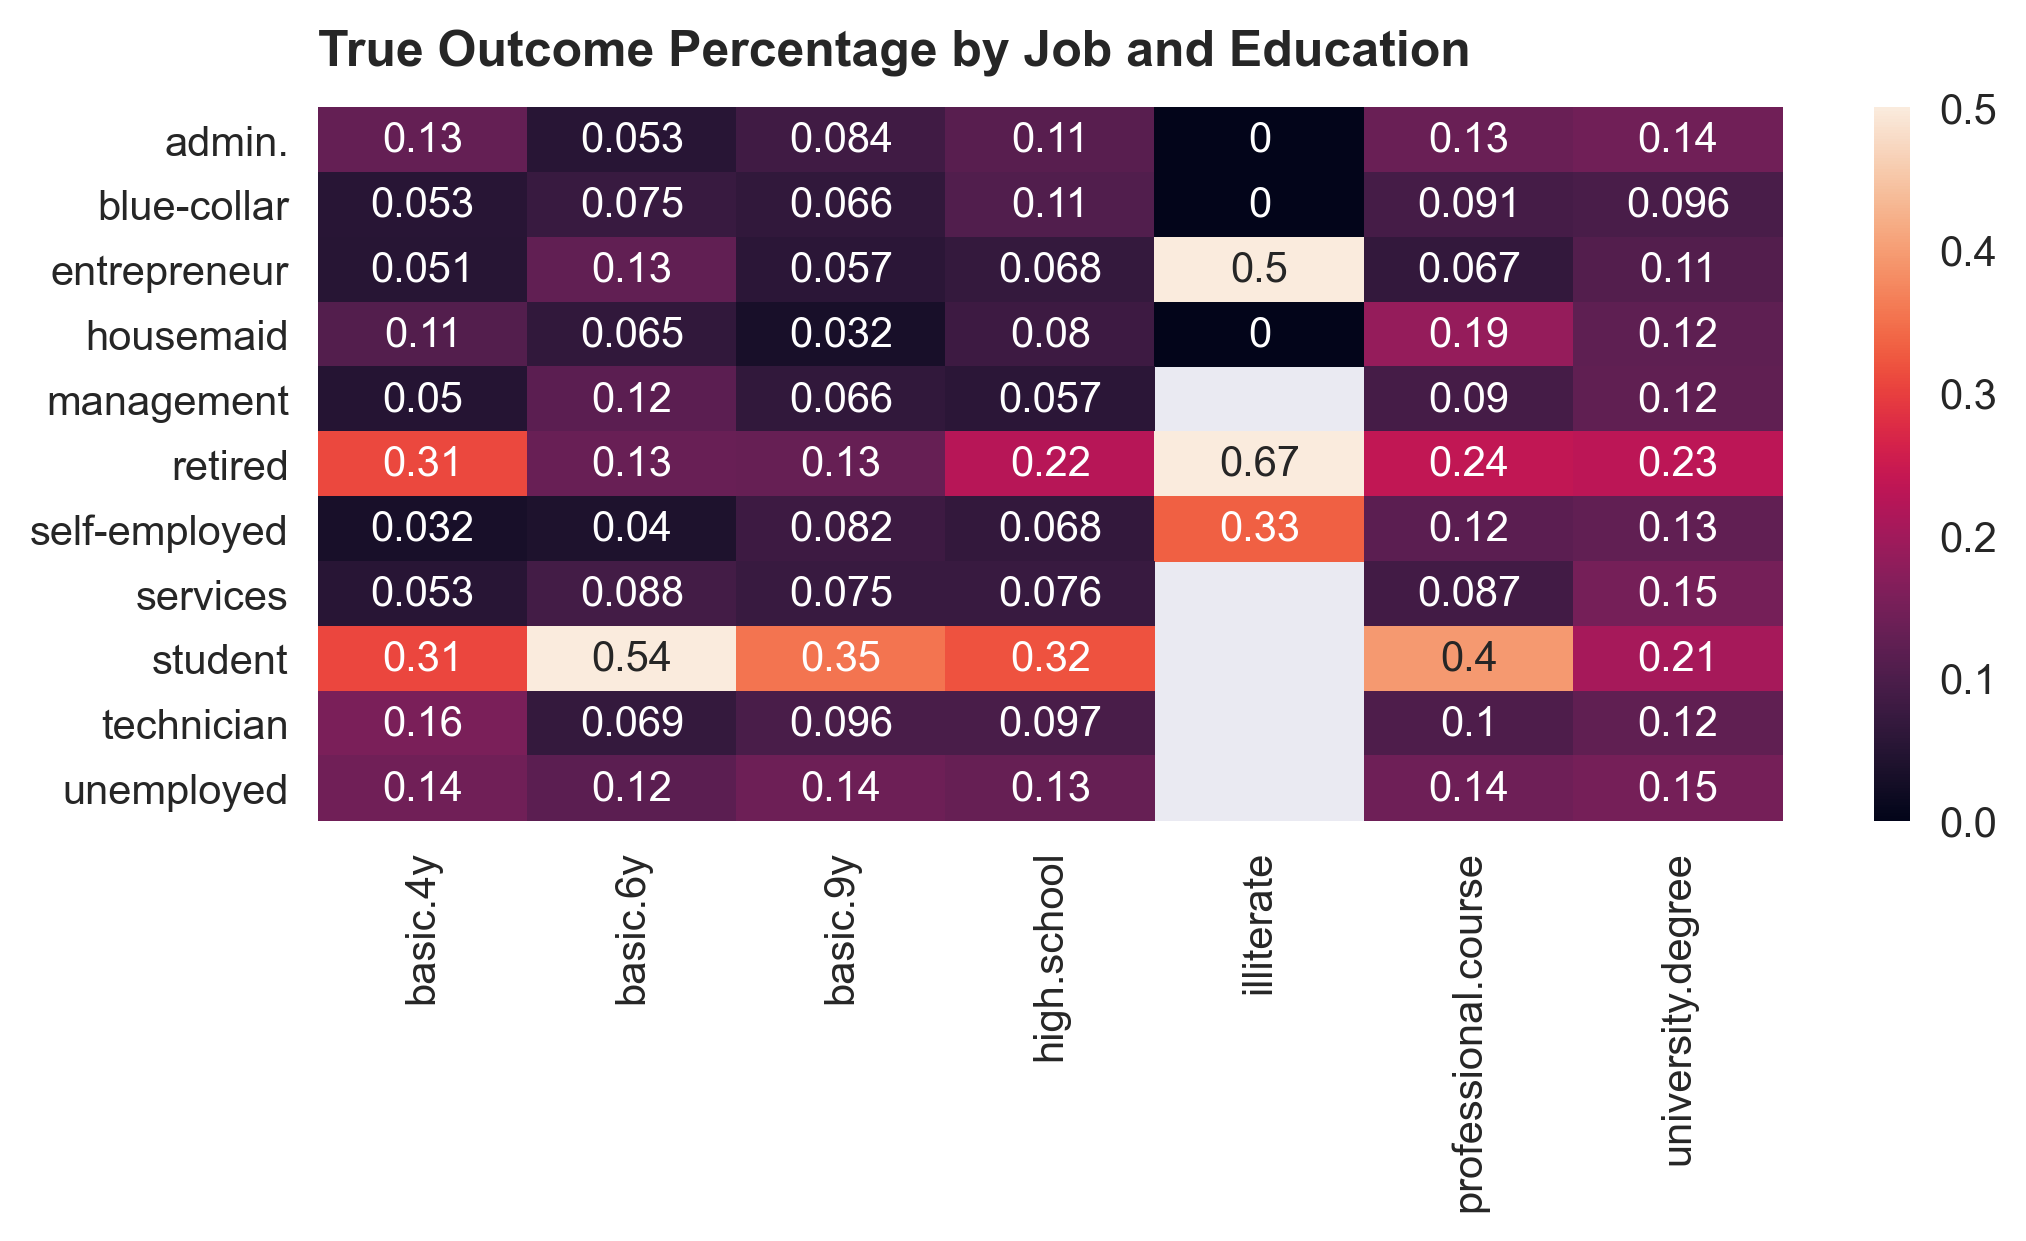

In [49]:
job_education_total = bank_mkt[["job", "education", "y"]].groupby(["job", "education"]).count().y.unstack()
job_education_true = bank_mkt[["job", "education", "y"]].groupby(["job", "education"]).sum().y.unstack()
job_education_rate = job_education_true / job_education_total
job_education_rate = job_education_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
job_education_heatmap = sns.heatmap(data=job_education_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Job and Education")

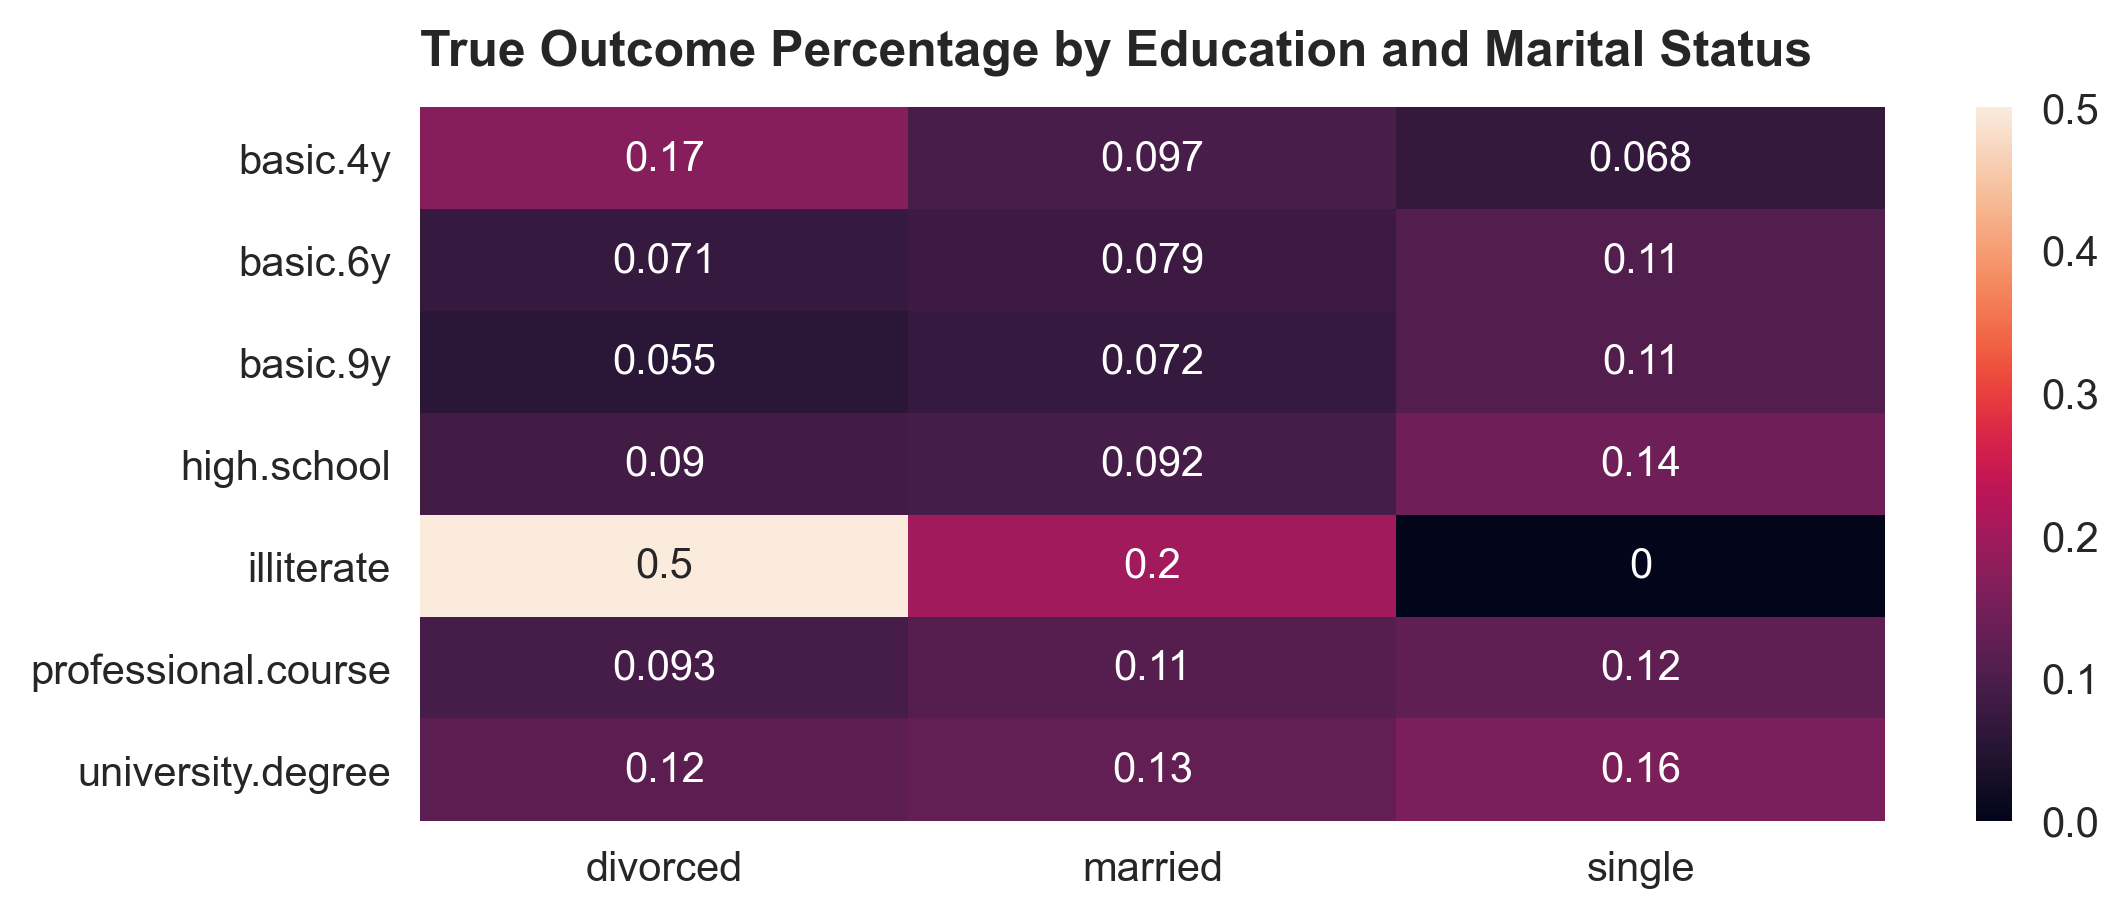

In [51]:
education_marital_total = bank_mkt[["education", "marital", "y"]].groupby(["education", "marital"]).count().y.unstack()
education_marital_true = bank_mkt[["education", "marital", "y"]].groupby(["education", "marital"]).sum().y.unstack()
education_marital_rate = education_marital_true / education_marital_total
education_marital_rate = education_marital_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
education_marital_heatmap = sns.heatmap(data=education_marital_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Education and Marital Status")

### Missing values

By checking the number of missing values, we can see nearly all client do not have `pdays` and `poutcome`. 20% of the clients do not have information of `default`.

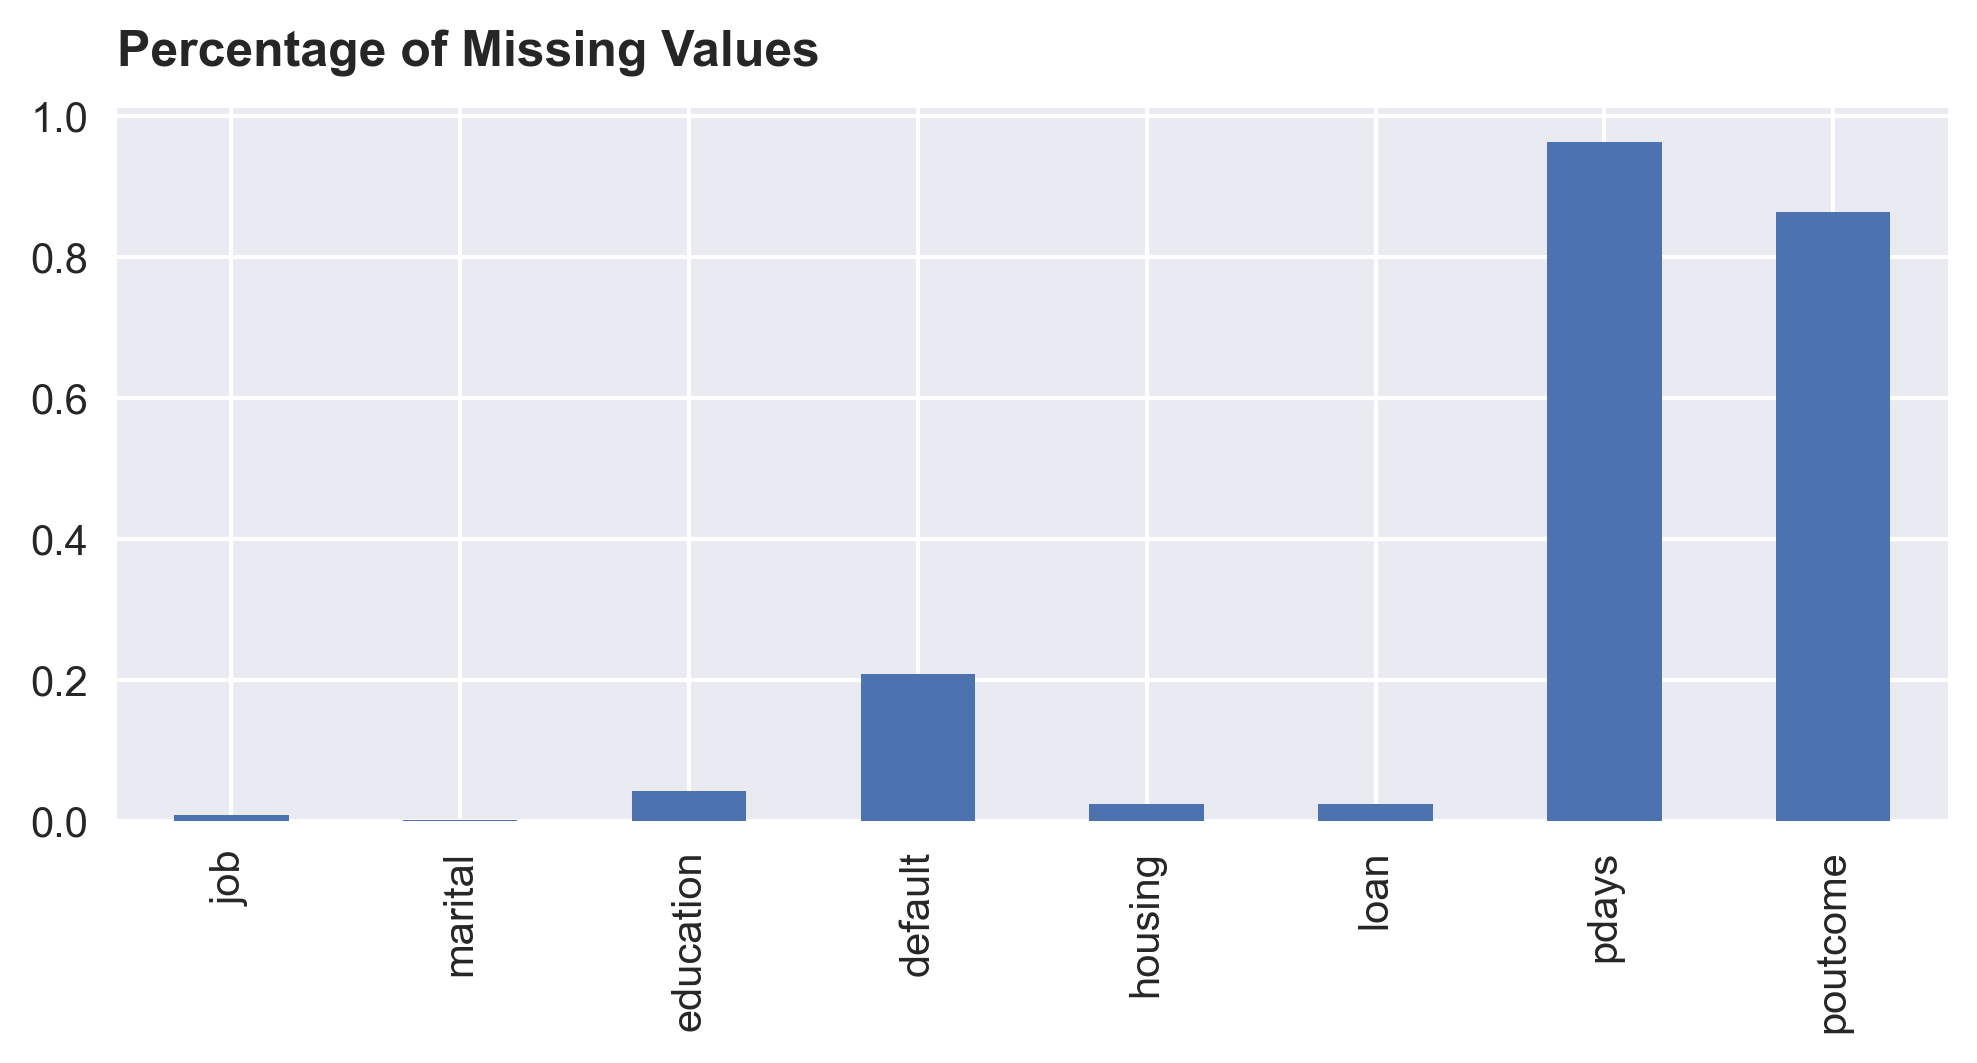

In [50]:
na = bank_mkt.isna().sum()
na_nonzero = na[na!=0]
na_perc = na_nonzero/bank_mkt.y.count()
na_bar = na_perc.plot.bar(title="Percentage of Missing Values")

`pdays` and `poutcome` are interesting. If `pdays` is missing value (999), that means that the client was not previously contacted and therefore should not have `poutcome`. But `poutcome` column has less missing values than `pdays`. We can print out the rows where the client is not contacted but have `poutcome`.`pdays` and `poutcome` are interesting.

In [84]:
client_other = bank_mkt[["campaign", "pdays", "previous", "poutcome", "y"]]
client_other[client_other["pdays"].isna() & client_other["poutcome"].notna()]

,campaign,pdays,previous,poutcome,y
24013,1,<NA>,1,False,False
24019,1,<NA>,1,False,True
24076,1,<NA>,1,False,False
24102,1,<NA>,1,False,True
24113,1,<NA>,1,False,False
...,...,...,...,...,...
41166,1,<NA>,1,False,True
41170,2,<NA>,4,False,False
41173,1,<NA>,2,False,True
41175,1,<NA>,2,False,False


In [85]:
client_other[client_other["pdays"].isna() & client_other["poutcome"].isna()]

,campaign,pdays,previous,poutcome,y
0,1,<NA>,0,<NA>,False
1,1,<NA>,0,<NA>,False
2,1,<NA>,0,<NA>,False
3,1,<NA>,0,<NA>,False
4,1,<NA>,0,<NA>,False
...,...,...,...,...,...
41181,1,<NA>,0,<NA>,True
41183,1,<NA>,0,<NA>,True
41184,1,<NA>,0,<NA>,False
41185,2,<NA>,0,<NA>,False


We can see for client with no previous contact, all of them have false outcome but have several previous contacts. We have several possiblities to treat this abnormal data:
- `poutcome` and `previous` are wrong and should be treated as missing value.
- `pdays` is wrong and should be replaced by the mean value.
- `pdays` is wrong and should be replaced by a very large value.
-  create a new feature to accomadate this kind of client.We can see for client with no previous contact, all of them have false outcome but have several previous contacts. We have several possiblities to treat this abnormal data:
- `poutcome` and `previous` are wrong and should be treated as missing value.
- `pdays` is wrong and should be replaced by the mean value.
- `pdays` is wrong and should be replaced by a very large value.
-  create a new feature to accomadate this kind of client.

### Correlation

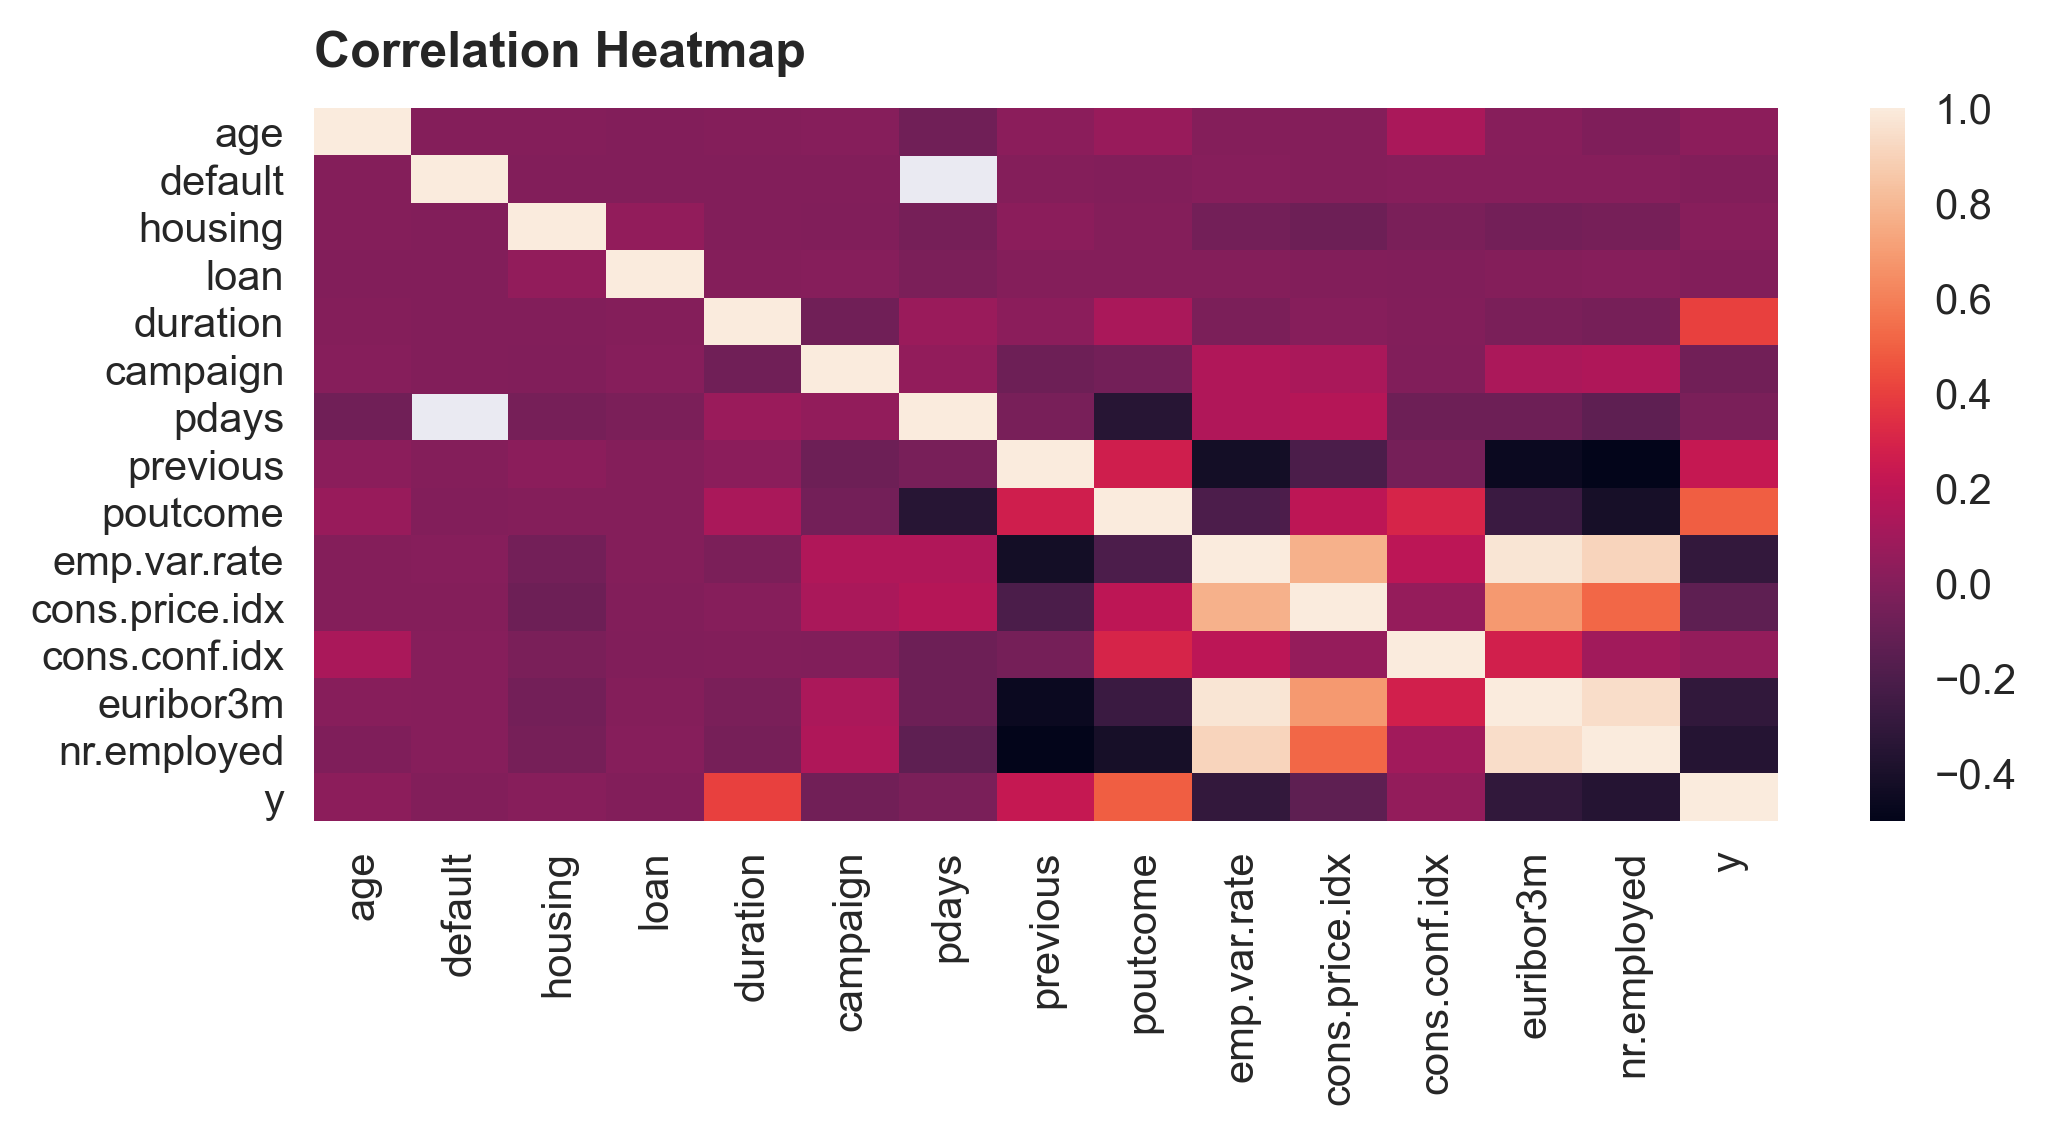

In [63]:
corr_heatmap = sns.heatmap(data=bank_mkt.corr(method="pearson")).set_title("Correlation Heatmap")